In [300]:
# note: ChatGPT was used to help develop this code

# Packages

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from osgeo import gdal
from sklearn import preprocessing
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.ticker as ticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

%matplotlib inline
from IPython.display import Image
from PIL import Image

# Functions

In [121]:
# georeferenced tiff image is inputted. width and height become latitude and longitude, and each of the three RGB channels are pulled out
def xyz_geotiff(img):
    band_r = img.GetRasterBand(1) # retrieves the red layer 
    z_r = np.flipud(band_r.ReadAsArray()).T

    band_g = img.GetRasterBand(2) # retrieves the green layer 
    z_g = np.flipud(band_g.ReadAsArray()).T 

    band_b = img.GetRasterBand(3) # retrieves the blue layer 
    z_b = np.flipud(band_b.ReadAsArray()).T
    
    width = img.RasterXSize 
    height = img.RasterYSize 
    
    gt = img.GetGeoTransform()                        

    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]

    # create linearly spaced arrays of lat and lon values where the length of the array is equal to the width or height of the image
    lon = np.linspace(minx,maxx,width)  
    lat = np.linspace(miny,maxy,height) 
    
    return lon, lat, z_r, z_g, z_b # returns the lat, lon, and red, green, blue values in arrays

In [3]:
def nans(red, green, blue):
    r = red.astype(float) # convert all pixels to floats
    g = green.astype(float) 
    b = blue.astype(float)

    r[r==255] = np.nan # assign nan values to all pixels with a value of 255 (this is all those outside the actual survey area)
    g[g==255] = np.nan 
    b[b==255] = np.nan

    return r, g, b

In [4]:
# function to return the maximum and minimum values in an array that excludes NaN values
def maxmin(array): 
    max = np.nanmax(array)
    min = np.nanmin(array)
    return max,min

In [5]:
# function to smooth histograms to extract local minima 
def smooth_histogram(hist_raw, sigma, plot_valleys=False, plot_peaks=False):    
    smoothed_hist = gaussian_filter1d(hist_raw, sigma=sigma)
    if plot_valleys:
        peaks, _ = find_peaks(-smoothed_hist)  # invert the smoothed histogram for finding valleys
        valleys = bins_raw[:-1][peaks]
        for valley in valleys:
            plt.axvline(valley, color='r', linestyle='--')  
            plt.text(valley, 0, str(int(valley)), color='r', rotation=90, va='bottom')
    if plot_peaks:
        peaks, _ = find_peaks(smoothed_hist)
        maxima_positions = bins_raw[:-1][peaks] 
        for maximum in maxima_positions:
            plt.axvline(maximum, color='g', linestyle='--')  
            plt.text(maximum, 0, str(int(maximum)), color='g', rotation=90, va='bottom')
            
    return smoothed_hist

In [6]:
# function to mask an array i.e., selectively marking nan elements as invalid and not to be used in computations
def mask(red, green, blue):
    maskr = np.ma.masked_invalid(red)
    maskg = np.ma.masked_invalid(green)
    maskb = np.ma.masked_invalid(blue)
    return maskr, maskg, maskb

In [7]:
# function to populate an empty array with 0 for vegetation, 1 for bare soil, and 2 for gibber
def vbg_mask(r_geotiff, g_geotiff, b_geotiff, r_mask, g_mask, b_mask):
    vbg = np.full((1000,1000), np.nan) 
    vbg[(r_mask < 160) & (g_mask < 160)] = 0
    vbg[~((r_mask < 160) & (g_mask < 160))] = 1
    vbg[(r_mask > 160) & (g_mask > 160) & (b_mask>135)] = 2
    vbg[(r_geotiff==255) & (g_geotiff==255) & (b_geotiff==255)] = np.nan # values outside of flight area are nan

    return vbg

In [8]:
# function to calculate gibber percentage in larger grid squares
def gibber_fraction(vbg_section):
    g_f = np.full((100,100), np.nan)

    for i in range(np.shape(g_f)[0]):
        for j in range(np.shape(g_f)[1]):
            temp = vbg_section[int(i*10) : int((i+1)*10+1)] [:, int(j*10) : int( (j+1)*10+1)]
            g_f[i,j] = (np.nansum(len(temp[temp==2])) / (np.nansum(len(temp[temp==0])) + np.nansum(len(temp[temp==1])) + np.nansum(len(temp[temp==2])))) * 100

    return g_f

# Load Data

In [195]:
# load in whole site orthomosaic file
data_geotiff = gdal.Open('smaller_2cm_ortho_kalabity.tif')

# load in sections of the pre-cropped orthomosaic file. All sections are in 1000x1000 pixels
data_geotiff_0_7 = gdal.Open('smaller_split_ortho_kalabity-0-7.tif')
data_geotiff_0_8 = gdal.Open('smaller_split_ortho_kalabity-0-8.tif')
data_geotiff_0_9 = gdal.Open('smaller_split_ortho_kalabity-0-9.tif')

data_geotiff_1_4 = gdal.Open('smaller_split_ortho_kalabity-1-4.tif')
data_geotiff_1_5 = gdal.Open('smaller_split_ortho_kalabity-1-5.tif')
data_geotiff_1_6 = gdal.Open('smaller_split_ortho_kalabity-1-6.tif')
data_geotiff_1_7 = gdal.Open('smaller_split_ortho_kalabity-1-7.tif')  
data_geotiff_1_8 = gdal.Open('smaller_split_ortho_kalabity-1-8.tif')  
data_geotiff_1_9 = gdal.Open('smaller_split_ortho_kalabity-1-9.tif')  
data_geotiff_1_10 = gdal.Open('smaller_split_ortho_kalabity-1-10.tif')  

data_geotiff_2_2 = gdal.Open('smaller_split_ortho_kalabity-2-2.tif')
data_geotiff_2_3 = gdal.Open('smaller_split_ortho_kalabity-2-3.tif')
data_geotiff_2_4 = gdal.Open('smaller_split_ortho_kalabity-2-4.tif')
data_geotiff_2_5 = gdal.Open('smaller_split_ortho_kalabity-2-5.tif')
data_geotiff_2_6 = gdal.Open('smaller_split_ortho_kalabity-2-6.tif')
data_geotiff_2_7 = gdal.Open('smaller_split_ortho_kalabity-2-7.tif')
data_geotiff_2_8 = gdal.Open('smaller_split_ortho_kalabity-2-8.tif')
data_geotiff_2_9 = gdal.Open('smaller_split_ortho_kalabity-2-9.tif')
data_geotiff_2_10 = gdal.Open('smaller_split_ortho_kalabity-2-10.tif')

data_geotiff_3_0 = gdal.Open('smaller_split_ortho_kalabity-3-0.tif')
data_geotiff_3_1 = gdal.Open('smaller_split_ortho_kalabity-3-1.tif')
data_geotiff_3_2 = gdal.Open('smaller_split_ortho_kalabity-3-2.tif')
data_geotiff_3_3 = gdal.Open('smaller_split_ortho_kalabity-3-3.tif')
data_geotiff_3_4 = gdal.Open('smaller_split_ortho_kalabity-3-4.tif')
data_geotiff_3_5 = gdal.Open('smaller_split_ortho_kalabity-3-5.tif')
data_geotiff_3_6 = gdal.Open('smaller_split_ortho_kalabity-3-6.tif')
data_geotiff_3_7 = gdal.Open('smaller_split_ortho_kalabity-3-7.tif')
data_geotiff_3_8 = gdal.Open('smaller_split_ortho_kalabity-3-8.tif')
data_geotiff_3_9 = gdal.Open('smaller_split_ortho_kalabity-3-9.tif')
data_geotiff_3_10 = gdal.Open('smaller_split_ortho_kalabity-3-10.tif')
data_geotiff_3_11 = gdal.Open('smaller_split_ortho_kalabity-3-11.tif')

data_geotiff_4_0 = gdal.Open('smaller_split_ortho_kalabity-4-0.tif')
data_geotiff_4_1 = gdal.Open('smaller_split_ortho_kalabity-4-1.tif')
data_geotiff_4_2 = gdal.Open('smaller_split_ortho_kalabity-4-2.tif')
data_geotiff_4_3 = gdal.Open('smaller_split_ortho_kalabity-4-3.tif')
data_geotiff_4_4 = gdal.Open('smaller_split_ortho_kalabity-4-4.tif')
data_geotiff_4_5 = gdal.Open('smaller_split_ortho_kalabity-4-5.tif')
data_geotiff_4_6 = gdal.Open('smaller_split_ortho_kalabity-4-6.tif') 
data_geotiff_4_7 = gdal.Open('smaller_split_ortho_kalabity-4-7.tif')
data_geotiff_4_8 = gdal.Open('smaller_split_ortho_kalabity-4-8.tif')
data_geotiff_4_9 = gdal.Open('smaller_split_ortho_kalabity-4-9.tif')
data_geotiff_4_10 = gdal.Open('smaller_split_ortho_kalabity-4-10.tif')
data_geotiff_4_11 = gdal.Open('smaller_split_ortho_kalabity-4-11.tif')

data_geotiff_5_0 = gdal.Open('smaller_split_ortho_kalabity-5-0.tif')
data_geotiff_5_1 = gdal.Open('smaller_split_ortho_kalabity-5-1.tif')
data_geotiff_5_2 = gdal.Open('smaller_split_ortho_kalabity-5-2.tif')
data_geotiff_5_3 = gdal.Open('smaller_split_ortho_kalabity-5-3.tif')
data_geotiff_5_4 = gdal.Open('smaller_split_ortho_kalabity-5-4.tif')
data_geotiff_5_5 = gdal.Open('smaller_split_ortho_kalabity-5-5.tif')
data_geotiff_5_6 = gdal.Open('smaller_split_ortho_kalabity-5-6.tif') 
data_geotiff_5_7 = gdal.Open('smaller_split_ortho_kalabity-5-7.tif')
data_geotiff_5_8 = gdal.Open('smaller_split_ortho_kalabity-5-8.tif')
data_geotiff_5_9 = gdal.Open('smaller_split_ortho_kalabity-5-9.tif')
data_geotiff_5_10 = gdal.Open('smaller_split_ortho_kalabity-5-10.tif')
data_geotiff_5_11 = gdal.Open('smaller_split_ortho_kalabity-5-11.tif')
data_geotiff_5_12 = gdal.Open('smaller_split_ortho_kalabity-5-12.tif')

data_geotiff_6_1 = gdal.Open('smaller_split_ortho_kalabity-6-1.tif')
data_geotiff_6_2 = gdal.Open('smaller_split_ortho_kalabity-6-2.tif')
data_geotiff_6_3 = gdal.Open('smaller_split_ortho_kalabity-6-3.tif')
data_geotiff_6_4 = gdal.Open('smaller_split_ortho_kalabity-6-4.tif')
data_geotiff_6_5 = gdal.Open('smaller_split_ortho_kalabity-6-5.tif')
data_geotiff_6_6 = gdal.Open('smaller_split_ortho_kalabity-6-6.tif') 
data_geotiff_6_7 = gdal.Open('smaller_split_ortho_kalabity-6-7.tif')
data_geotiff_6_8 = gdal.Open('smaller_split_ortho_kalabity-6-8.tif')
data_geotiff_6_9 = gdal.Open('smaller_split_ortho_kalabity-6-9.tif')
data_geotiff_6_10 = gdal.Open('smaller_split_ortho_kalabity-6-10.tif')
data_geotiff_6_11 = gdal.Open('smaller_split_ortho_kalabity-6-11.tif')
data_geotiff_6_12 = gdal.Open('smaller_split_ortho_kalabity-6-12.tif')

data_geotiff_7_1 = gdal.Open('smaller_split_ortho_kalabity-7-1.tif')
data_geotiff_7_2 = gdal.Open('smaller_split_ortho_kalabity-7-2.tif')
data_geotiff_7_3 = gdal.Open('smaller_split_ortho_kalabity-7-3.tif')
data_geotiff_7_4 = gdal.Open('smaller_split_ortho_kalabity-7-4.tif')
data_geotiff_7_5 = gdal.Open('smaller_split_ortho_kalabity-7-5.tif')
data_geotiff_7_6 = gdal.Open('smaller_split_ortho_kalabity-7-6.tif') 
data_geotiff_7_7 = gdal.Open('smaller_split_ortho_kalabity-7-7.tif')
data_geotiff_7_8 = gdal.Open('smaller_split_ortho_kalabity-7-8.tif')
data_geotiff_7_9 = gdal.Open('smaller_split_ortho_kalabity-7-9.tif')
data_geotiff_7_10 = gdal.Open('smaller_split_ortho_kalabity-7-10.tif')
data_geotiff_7_11 = gdal.Open('smaller_split_ortho_kalabity-7-11.tif')
data_geotiff_7_12 = gdal.Open('smaller_split_ortho_kalabity-7-12.tif')
data_geotiff_7_13 = gdal.Open('smaller_split_ortho_kalabity-7-13.tif')

data_geotiff_8_2 = gdal.Open('smaller_split_ortho_kalabity-8-2.tif')
data_geotiff_8_3 = gdal.Open('smaller_split_ortho_kalabity-8-3.tif')
data_geotiff_8_4 = gdal.Open('smaller_split_ortho_kalabity-8-4.tif')
data_geotiff_8_5 = gdal.Open('smaller_split_ortho_kalabity-8-5.tif')
data_geotiff_8_6 = gdal.Open('smaller_split_ortho_kalabity-8-6.tif')
data_geotiff_8_7 = gdal.Open('smaller_split_ortho_kalabity-8-7.tif')
data_geotiff_8_8 = gdal.Open('smaller_split_ortho_kalabity-8-8.tif')
data_geotiff_8_9 = gdal.Open('smaller_split_ortho_kalabity-8-9.tif')
data_geotiff_8_10 = gdal.Open('smaller_split_ortho_kalabity-8-10.tif')
data_geotiff_8_11 = gdal.Open('smaller_split_ortho_kalabity-8-11.tif')
data_geotiff_8_12 = gdal.Open('smaller_split_ortho_kalabity-8-12.tif')
data_geotiff_8_13 = gdal.Open('smaller_split_ortho_kalabity-8-13.tif')

data_geotiff_9_2 = gdal.Open('smaller_split_ortho_kalabity-9-2.tif')
data_geotiff_9_3 = gdal.Open('smaller_split_ortho_kalabity-9-3.tif')
data_geotiff_9_4 = gdal.Open('smaller_split_ortho_kalabity-9-4.tif')
data_geotiff_9_5 = gdal.Open('smaller_split_ortho_kalabity-9-5.tif')
data_geotiff_9_6 = gdal.Open('smaller_split_ortho_kalabity-9-6.tif')
data_geotiff_9_7 = gdal.Open('smaller_split_ortho_kalabity-9-7.tif')
data_geotiff_9_8 = gdal.Open('smaller_split_ortho_kalabity-9-8.tif')
data_geotiff_9_9 = gdal.Open('smaller_split_ortho_kalabity-9-9.tif')
data_geotiff_9_10 = gdal.Open('smaller_split_ortho_kalabity-9-10.tif')
data_geotiff_9_11 = gdal.Open('smaller_split_ortho_kalabity-9-11.tif')
data_geotiff_9_12 = gdal.Open('smaller_split_ortho_kalabity-9-12.tif')
data_geotiff_9_13 = gdal.Open('smaller_split_ortho_kalabity-9-13.tif')

data_geotiff_10_3 = gdal.Open('smaller_split_ortho_kalabity-10-3.tif')
data_geotiff_10_4 = gdal.Open('smaller_split_ortho_kalabity-10-4.tif')
data_geotiff_10_5 = gdal.Open('smaller_split_ortho_kalabity-10-5.tif')
data_geotiff_10_6 = gdal.Open('smaller_split_ortho_kalabity-10-6.tif')
data_geotiff_10_7 = gdal.Open('smaller_split_ortho_kalabity-10-7.tif')
data_geotiff_10_8 = gdal.Open('smaller_split_ortho_kalabity-10-8.tif')
data_geotiff_10_9 = gdal.Open('smaller_split_ortho_kalabity-10-9.tif')
data_geotiff_10_10 = gdal.Open('smaller_split_ortho_kalabity-10-10.tif')
data_geotiff_10_11 = gdal.Open('smaller_split_ortho_kalabity-10-11.tif')

data_geotiff_11_3 = gdal.Open('smaller_split_ortho_kalabity-11-3.tif')
data_geotiff_11_4 = gdal.Open('smaller_split_ortho_kalabity-11-4.tif')
data_geotiff_11_5 = gdal.Open('smaller_split_ortho_kalabity-11-5.tif')
data_geotiff_11_6 = gdal.Open('smaller_split_ortho_kalabity-11-6.tif')
data_geotiff_11_7 = gdal.Open('smaller_split_ortho_kalabity-11-7.tif')
data_geotiff_11_8 = gdal.Open('smaller_split_ortho_kalabity-11-8.tif')
data_geotiff_11_9 = gdal.Open('smaller_split_ortho_kalabity-11-9.tif')

data_geotiff_12_4 = gdal.Open('smaller_split_ortho_kalabity-12-4.tif')
data_geotiff_12_5 = gdal.Open('smaller_split_ortho_kalabity-12-5.tif')
data_geotiff_12_6 = gdal.Open('smaller_split_ortho_kalabity-12-6.tif')
data_geotiff_12_7 = gdal.Open('smaller_split_ortho_kalabity-12-7.tif')

data_geotiff_13_4 = gdal.Open('smaller_split_ortho_kalabity-13-4.tif')
data_geotiff_13_5 = gdal.Open('smaller_split_ortho_kalabity-13-5.tif')

In [4]:
# load the whole site and some some example sections
image_path = "smaller_2cm_ortho_kalabity.tif"
image = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-1-7.tif"
image17 = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-3-4.tif"
image34 = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-4-6.tif"
image46 = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-8-8.tif"
image88 = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-0-7.tif"
image07 = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-0-8.tif"
image08 = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-0-9.tif"
image09 = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-1-4.tif"
image14 = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-1-5.tif"
image15 = Image.open(image_path)

image_path = "smaller_split_ortho_kalabity-1-6.tif"
image16 = Image.open(image_path)

# Analysis

In [202]:
# whole site
lon, lat, red, green, blue = xyz_geotiff(data_geotiff)

In [196]:
# for each section, assign latitude, longitude and each RBG band to a variable
lon_0_7, lat_0_7, red07, green07, blue07 = xyz_geotiff(data_geotiff_0_7)
lon_0_8, lat_0_8, red08, green08, blue08 = xyz_geotiff(data_geotiff_0_8)
lon_0_9, lat_0_9, red09, green09, blue09 = xyz_geotiff(data_geotiff_0_9)

lon_1_4, lat_1_4, red14, green14, blue14 = xyz_geotiff(data_geotiff_1_4)
lon_1_5, lat_1_5, red15, green15, blue15 = xyz_geotiff(data_geotiff_1_5)
lon_1_6, lat_1_6, red16, green16, blue16 = xyz_geotiff(data_geotiff_1_6)
lon_1_7, lat_1_7, red17, green17, blue17 = xyz_geotiff(data_geotiff_1_7)
lon_1_8, lat_1_8, red18, green18, blue18 = xyz_geotiff(data_geotiff_1_8)
lon_1_9, lat_1_9, red19, green19, blue19 = xyz_geotiff(data_geotiff_1_9)
lon_1_10, lat_1_10, red110, green110, blue110 = xyz_geotiff(data_geotiff_1_10)

lon_2_2, lat_2_2, red22, green22, blue22 = xyz_geotiff(data_geotiff_2_2) 
lon_2_3, lat_2_3, red23, green23, blue23 = xyz_geotiff(data_geotiff_2_3) 
lon_2_4, lat_2_4, red24, green24, blue24 = xyz_geotiff(data_geotiff_2_4) 
lon_2_5, lat_2_5, red25, green25, blue25 = xyz_geotiff(data_geotiff_2_5) 
lon_2_6, lat_2_6, red26, green26, blue26 = xyz_geotiff(data_geotiff_2_6) 
lon_2_7, lat_2_7, red27, green27, blue27 = xyz_geotiff(data_geotiff_2_7) 
lon_2_8, lat_2_8, red28, green28, blue28 = xyz_geotiff(data_geotiff_2_8) 
lon_2_9, lat_2_9, red29, green29, blue29 = xyz_geotiff(data_geotiff_2_9) 
lon_2_10, lat_2_10, red210, green210, blue210 = xyz_geotiff(data_geotiff_2_10) 

lon_3_0, lat_3_0, red30, green30, blue30 = xyz_geotiff(data_geotiff_3_0) 
lon_3_1, lat_3_1, red31, green31, blue31 = xyz_geotiff(data_geotiff_3_1) 
lon_3_2, lat_3_2, red32, green32, blue32 = xyz_geotiff(data_geotiff_3_2) 
lon_3_3, lat_3_3, red33, green33, blue33 = xyz_geotiff(data_geotiff_3_3) 
lon_3_4, lat_3_4, red34, green34, blue34 = xyz_geotiff(data_geotiff_3_4) 
lon_3_5, lat_3_5, red35, green35, blue35 = xyz_geotiff(data_geotiff_3_5) 
lon_3_6, lat_3_6, red36, green36, blue36 = xyz_geotiff(data_geotiff_3_6) 
lon_3_7, lat_3_7, red37, green37, blue37 = xyz_geotiff(data_geotiff_3_7) 
lon_3_8, lat_3_8, red38, green38, blue38 = xyz_geotiff(data_geotiff_3_8) 
lon_3_9, lat_3_9, red39, green39, blue39 = xyz_geotiff(data_geotiff_3_9) 
lon_3_10, lat_3_10, red310, green310, blue310 = xyz_geotiff(data_geotiff_3_10) 
lon_3_11, lat_3_11, red311, green311, blue311 = xyz_geotiff(data_geotiff_3_11) 

lon_4_0, lat_4_0, red40, green40, blue40 = xyz_geotiff(data_geotiff_4_0) 
lon_4_1, lat_4_1, red41, green41, blue41 = xyz_geotiff(data_geotiff_4_1) 
lon_4_2, lat_4_2, red42, green42, blue42 = xyz_geotiff(data_geotiff_4_2) 
lon_4_3, lat_4_3, red43, green43, blue43 = xyz_geotiff(data_geotiff_4_3) 
lon_4_4, lat_4_4, red44, green44, blue44 = xyz_geotiff(data_geotiff_4_4) 
lon_4_5, lat_4_5, red45, green45, blue45 = xyz_geotiff(data_geotiff_4_5) 
lon_4_6, lat_4_6, red46, green46, blue46 = xyz_geotiff(data_geotiff_4_6) 
lon_4_7, lat_4_7, red47, green47, blue47 = xyz_geotiff(data_geotiff_4_7) 
lon_4_8, lat_4_8, red48, green48, blue48 = xyz_geotiff(data_geotiff_4_8) 
lon_4_9, lat_4_9, red49, green49, blue49 = xyz_geotiff(data_geotiff_4_9) 
lon_4_10, lat_4_10, red410, green410, blue410 = xyz_geotiff(data_geotiff_4_10) 
lon_4_11, lat_4_11, red411, green411, blue411 = xyz_geotiff(data_geotiff_4_11) 

lon_5_0, lat_5_0, red50, green50, blue50 = xyz_geotiff(data_geotiff_5_0) 
lon_5_1, lat_5_1, red51, green51, blue51 = xyz_geotiff(data_geotiff_5_1) 
lon_5_2, lat_5_2, red52, green52, blue52 = xyz_geotiff(data_geotiff_5_2) 
lon_5_3, lat_5_3, red53, green53, blue53 = xyz_geotiff(data_geotiff_5_3) 
lon_5_4, lat_5_4, red54, green54, blue54 = xyz_geotiff(data_geotiff_5_4) 
lon_5_5, lat_5_5, red55, green55, blue55 = xyz_geotiff(data_geotiff_5_5) 
lon_5_6, lat_5_6, red56, green56, blue56 = xyz_geotiff(data_geotiff_5_6) 
lon_5_7, lat_5_7, red57, green57, blue57 = xyz_geotiff(data_geotiff_5_7) 
lon_5_8, lat_5_8, red58, green58, blue58 = xyz_geotiff(data_geotiff_5_8) 
lon_5_9, lat_5_9, red59, green59, blue59 = xyz_geotiff(data_geotiff_5_9) 
lon_5_10, lat_5_10, red510, green510, blue510 = xyz_geotiff(data_geotiff_5_10) 
lon_5_11, lat_5_11, red511, green511, blue511 = xyz_geotiff(data_geotiff_5_11) 
lon_5_12, lat_5_12, red512, green512, blue512 = xyz_geotiff(data_geotiff_5_12) 

lon_6_1, lat_6_1, red61, green61, blue61 = xyz_geotiff(data_geotiff_6_1) 
lon_6_2, lat_6_2, red62, green62, blue62 = xyz_geotiff(data_geotiff_6_2) 
lon_6_3, lat_6_3, red63, green63, blue63 = xyz_geotiff(data_geotiff_6_3) 
lon_6_4, lat_6_4, red64, green64, blue64 = xyz_geotiff(data_geotiff_6_4) 
lon_6_5, lat_6_5, red65, green65, blue65 = xyz_geotiff(data_geotiff_6_5) 
lon_6_6, lat_6_6, red66, green66, blue66 = xyz_geotiff(data_geotiff_6_6) 
lon_6_7, lat_6_7, red67, green67, blue67 = xyz_geotiff(data_geotiff_6_7) 
lon_6_8, lat_6_8, red68, green68, blue68 = xyz_geotiff(data_geotiff_6_8) 
lon_6_9, lat_6_9, red69, green69, blue69 = xyz_geotiff(data_geotiff_6_9) 
lon_6_10, lat_6_10, red610, green610, blue610 = xyz_geotiff(data_geotiff_6_10) 
lon_6_11, lat_6_11, red611, green611, blue611 = xyz_geotiff(data_geotiff_6_11) 
lon_6_12, lat_6_12, red612, green612, blue612 = xyz_geotiff(data_geotiff_6_12) 

lon_7_1, lat_7_1, red71, green71, blue71 = xyz_geotiff(data_geotiff_7_1) 
lon_7_2, lat_7_2, red72, green72, blue72 = xyz_geotiff(data_geotiff_7_2) 
lon_7_3, lat_7_3, red73, green73, blue73 = xyz_geotiff(data_geotiff_7_3) 
lon_7_4, lat_7_4, red74, green74, blue74 = xyz_geotiff(data_geotiff_7_4) 
lon_7_5, lat_7_5, red75, green75, blue75 = xyz_geotiff(data_geotiff_7_5) 
lon_7_6, lat_7_6, red76, green76, blue76 = xyz_geotiff(data_geotiff_7_6) 
lon_7_7, lat_7_7, red77, green77, blue77 = xyz_geotiff(data_geotiff_7_7) 
lon_7_8, lat_7_8, red78, green78, blue78 = xyz_geotiff(data_geotiff_7_8) 
lon_7_9, lat_7_9, red79, green79, blue79 = xyz_geotiff(data_geotiff_7_9) 
lon_7_10, lat_7_10, red710, green710, blue710 = xyz_geotiff(data_geotiff_7_10) 
lon_7_11, lat_7_11, red711, green711, blue711 = xyz_geotiff(data_geotiff_7_11) 
lon_7_12, lat_7_12, red712, green712, blue712 = xyz_geotiff(data_geotiff_7_12) 
lon_7_13, lat_7_13, red713, green713, blue713 = xyz_geotiff(data_geotiff_7_13) 

lon_8_2, lat_8_2, red82, green82, blue82 = xyz_geotiff(data_geotiff_8_2) 
lon_8_3, lat_8_3, red83, green83, blue83 = xyz_geotiff(data_geotiff_8_3) 
lon_8_4, lat_8_4, red84, green84, blue84 = xyz_geotiff(data_geotiff_8_4) 
lon_8_5, lat_8_5, red85, green85, blue85 = xyz_geotiff(data_geotiff_8_5) 
lon_8_6, lat_8_6, red86, green86, blue86 = xyz_geotiff(data_geotiff_8_6) 
lon_8_7, lat_8_7, red87, green87, blue87 = xyz_geotiff(data_geotiff_8_7) 
lon_8_8, lat_8_8, red88, green88, blue88 = xyz_geotiff(data_geotiff_8_8) 
lon_8_9, lat_8_9, red89, green89, blue89 = xyz_geotiff(data_geotiff_8_9) 
lon_8_10, lat_8_10, red810, green810, blue810 = xyz_geotiff(data_geotiff_8_10) 
lon_8_11, lat_8_11, red811, green811, blue811 = xyz_geotiff(data_geotiff_8_11) 
lon_8_12, lat_8_12, red812, green812, blue812 = xyz_geotiff(data_geotiff_8_12) 
lon_8_13, lat_8_13, red813, green813, blue813 = xyz_geotiff(data_geotiff_8_13) 

lon_9_2, lat_9_2, red92, green92, blue92 = xyz_geotiff(data_geotiff_9_2) 
lon_9_3, lat_9_3, red93, green93, blue93 = xyz_geotiff(data_geotiff_9_3) 
lon_9_4, lat_9_4, red94, green94, blue94 = xyz_geotiff(data_geotiff_9_4) 
lon_9_5, lat_9_5, red95, green95, blue95 = xyz_geotiff(data_geotiff_9_5) 
lon_9_6, lat_9_6, red96, green96, blue96 = xyz_geotiff(data_geotiff_9_6) 
lon_9_7, lat_9_7, red97, green97, blue97 = xyz_geotiff(data_geotiff_9_7) 
lon_9_8, lat_9_8, red98, green98, blue98 = xyz_geotiff(data_geotiff_9_8) 
lon_9_9, lat_9_9, red99, green99, blue99 = xyz_geotiff(data_geotiff_9_9) 
lon_9_10, lat_9_10, red910, green910, blue910 = xyz_geotiff(data_geotiff_9_10) 
lon_9_11, lat_9_11, red911, green911, blue911 = xyz_geotiff(data_geotiff_9_11) 
lon_9_12, lat_9_12, red912, green912, blue912 = xyz_geotiff(data_geotiff_9_12) 
lon_9_13, lat_9_13, red913, green913, blue913 = xyz_geotiff(data_geotiff_9_13)  

lon_10_3, lat_10_3, red103, green103, blue103 = xyz_geotiff(data_geotiff_10_3) 
lon_10_4, lat_10_4, red104, green104, blue104 = xyz_geotiff(data_geotiff_10_4) 
lon_10_5, lat_10_5, red105, green105, blue105 = xyz_geotiff(data_geotiff_10_5) 
lon_10_6, lat_10_6, red106, green106, blue106 = xyz_geotiff(data_geotiff_10_6) 
lon_10_7, lat_10_7, red107, green107, blue107 = xyz_geotiff(data_geotiff_10_7) 
lon_10_8, lat_10_8, red108, green108, blue108 = xyz_geotiff(data_geotiff_10_8) 
lon_10_9, lat_10_9, red109, green109, blue109 = xyz_geotiff(data_geotiff_10_9) 
lon_10_10, lat_10_10, red1010, green1010, blue1010 = xyz_geotiff(data_geotiff_10_10) 
lon_10_11, lat_10_11, red1011, green1011, blue1011 = xyz_geotiff(data_geotiff_10_11) 

lon_11_3, lat_11_3, red113, green113, blue113 = xyz_geotiff(data_geotiff_11_3) 
lon_11_4, lat_11_4, red114, green114, blue114 = xyz_geotiff(data_geotiff_11_4) 
lon_11_5, lat_11_5, red115, green115, blue115 = xyz_geotiff(data_geotiff_11_5) 
lon_11_6, lat_11_6, red116, green116, blue116 = xyz_geotiff(data_geotiff_11_6) 
lon_11_7, lat_11_7, red117, green117, blue117 = xyz_geotiff(data_geotiff_11_7) 
lon_11_8, lat_11_8, red118, green118, blue118 = xyz_geotiff(data_geotiff_11_8) 
lon_11_9, lat_11_9, red119, green119, blue119 = xyz_geotiff(data_geotiff_11_9) 

lon_12_4, lat_12_4, red124, green124, blue124 = xyz_geotiff(data_geotiff_12_4) 
lon_12_5, lat_12_5, red125, green125, blue125 = xyz_geotiff(data_geotiff_12_5) 
lon_12_6, lat_12_6, red126, green126, blue126 = xyz_geotiff(data_geotiff_12_6) 
lon_12_7, lat_12_7, red127, green127, blue127 = xyz_geotiff(data_geotiff_12_7) 

lon_13_4, lat_13_4, red134, green134, blue134 = xyz_geotiff(data_geotiff_13_4) 
lon_13_5, lat_13_5, red135, green135, blue135 = xyz_geotiff(data_geotiff_13_5)

In [197]:
# for each section, remove values outside the actual data area i.e., brightness values of 255
r_0_7, g_0_7, b_0_7 = nans(red07, green07, blue07)
r_0_8, g_0_8, b_0_8 = nans(red08, green08, blue08)
r_0_9, g_0_9, b_0_9 = nans(red09, green09, blue09)

r_1_4, g_1_4, b_1_4 = nans(red14, green14, blue14)
r_1_5, g_1_5, b_1_5 = nans(red15, green15, blue15)
r_1_6, g_1_6, b_1_6 = nans(red16, green16, blue16)
r_1_7, g_1_7, b_1_7 = nans(red17, green17, blue17)
r_1_8, g_1_8, b_1_8 = nans(red18, green18, blue18)
r_1_9, g_1_9, b_1_9 = nans(red19, green19, blue19)
r_1_10, g_1_10, b_1_10 = nans(red110, green110, blue110)

r_2_2, g_2_2, b_2_2 = nans(red22, green22, blue22)
r_2_3, g_2_3, b_2_3 = nans(red23, green23, blue23)
r_2_4, g_2_4, b_2_4 = nans(red24, green24, blue24)
r_2_5, g_2_5, b_2_5 = nans(red25, green25, blue25)
r_2_6, g_2_6, b_2_6 = nans(red26, green26, blue26)
r_2_7, g_2_7, b_2_7 = nans(red27, green27, blue27)
r_2_8, g_2_8, b_2_8 = nans(red28, green28, blue28)
r_2_9, g_2_9, b_2_9 = nans(red29, green29, blue29)
r_2_10, g_2_10, b_2_10 = nans(red210, green210, blue210)

r_3_0, g_3_0, b_3_0 = nans(red30, green30, blue30)
r_3_1, g_3_1, b_3_1 = nans(red31, green31, blue31)
r_3_2, g_3_2, b_3_2 = nans(red32, green32, blue32)
r_3_3, g_3_3, b_3_3 = nans(red33, green33, blue33)
r_3_4, g_3_4, b_3_4 = nans(red34, green34, blue34)
r_3_5, g_3_5, b_3_5 = nans(red35, green35, blue35)
r_3_6, g_3_6, b_3_6 = nans(red36, green36, blue36)
r_3_7, g_3_7, b_3_7 = nans(red37, green37, blue37)
r_3_8, g_3_8, b_3_8 = nans(red38, green38, blue38)
r_3_9, g_3_9, b_3_9 = nans(red39, green39, blue39)
r_3_10, g_3_10, b_3_10 = nans(red310, green310, blue310)
r_3_11, g_3_11, b_3_11 = nans(red311, green311, blue311)

r_4_0, g_4_0, b_4_0 = nans(red40, green40, blue40)
r_4_1, g_4_1, b_4_1 = nans(red41, green41, blue41)
r_4_2, g_4_2, b_4_2 = nans(red42, green42, blue42)
r_4_3, g_4_3, b_4_3 = nans(red43, green43, blue43)
r_4_4, g_4_4, b_4_4 = nans(red44, green44, blue44)
r_4_5, g_4_5, b_4_5 = nans(red45, green45, blue45)
r_4_6, g_4_6, b_4_6 = nans(red46, green46, blue46) 
r_4_7, g_4_7, b_4_7 = nans(red47, green47, blue47)
r_4_8, g_4_8, b_4_8 = nans(red48, green48, blue48)
r_4_9, g_4_9, b_4_9 = nans(red49, green49, blue49)
r_4_10, g_4_10, b_4_10 = nans(red410, green410, blue410)
r_4_11, g_4_11, b_4_11 = nans(red411, green411, blue411)

r_5_0, g_5_0, b_5_0 = nans(red50, green50, blue50)
r_5_1, g_5_1, b_5_1 = nans(red51, green51, blue51)
r_5_2, g_5_2, b_5_2 = nans(red52, green52, blue52)
r_5_3, g_5_3, b_5_3 = nans(red53, green53, blue53)
r_5_4, g_5_4, b_5_4 = nans(red54, green54, blue54)
r_5_5, g_5_5, b_5_5 = nans(red55, green55, blue55)
r_5_6, g_5_6, b_5_6 = nans(red56, green56, blue56) 
r_5_7, g_5_7, b_5_7 = nans(red57, green57, blue57)
r_5_8, g_5_8, b_5_8 = nans(red58, green58, blue58)
r_5_9, g_5_9, b_5_9 = nans(red59, green59, blue59)
r_5_10, g_5_10, b_5_10 = nans(red510, green510, blue510)
r_5_11, g_5_11, b_5_11 = nans(red511, green511, blue511)
r_5_12, g_5_12, b_5_12 = nans(red512, green512, blue512)

r_6_1, g_6_1, b_6_1 = nans(red61, green61, blue61)
r_6_2, g_6_2, b_6_2 = nans(red62, green62, blue62)
r_6_3, g_6_3, b_6_3 = nans(red63, green63, blue63)
r_6_4, g_6_4, b_6_4 = nans(red64, green64, blue64)
r_6_5, g_6_5, b_6_5 = nans(red65, green65, blue65)
r_6_6, g_6_6, b_6_6 = nans(red66, green66, blue66) 
r_6_7, g_6_7, b_6_7 = nans(red67, green67, blue67)
r_6_8, g_6_8, b_6_8 = nans(red68, green68, blue68)
r_6_9, g_6_9, b_6_9 = nans(red69, green69, blue69)
r_6_10, g_6_10, b_6_10 = nans(red610, green610, blue610)
r_6_11, g_6_11, b_6_11 = nans(red611, green611, blue611)
r_6_12, g_6_12, b_6_12 = nans(red612, green612, blue612)

r_7_1, g_7_1, b_7_1 = nans(red71, green71, blue71)
r_7_2, g_7_2, b_7_2 = nans(red72, green72, blue72)
r_7_3, g_7_3, b_7_3 = nans(red73, green73, blue73)
r_7_4, g_7_4, b_7_4 = nans(red74, green74, blue74)
r_7_5, g_7_5, b_7_5 = nans(red75, green75, blue75)
r_7_6, g_7_6, b_7_6 = nans(red76, green76, blue76) 
r_7_7, g_7_7, b_7_7 = nans(red77, green77, blue77)
r_7_8, g_7_8, b_7_8 = nans(red78, green78, blue78)
r_7_9, g_7_9, b_7_9 = nans(red79, green79, blue79)
r_7_10, g_7_10, b_7_10 = nans(red710, green710, blue710)
r_7_11, g_7_11, b_7_11 = nans(red711, green711, blue711)
r_7_12, g_7_12, b_7_12 = nans(red712, green712, blue712)
r_7_13, g_7_13, b_7_13 = nans(red713, green713, blue713)

r_8_2, g_8_2, b_8_2 = nans(red82, green82, blue82)
r_8_3, g_8_3, b_8_3 = nans(red83, green83, blue83)
r_8_4, g_8_4, b_8_4 = nans(red84, green84, blue84)
r_8_5, g_8_5, b_8_5 = nans(red85, green85, blue85)
r_8_6, g_8_6, b_8_6 = nans(red86, green86, blue86) 
r_8_7, g_8_7, b_8_7 = nans(red87, green87, blue87)
r_8_8, g_8_8, b_8_8 = nans(red88, green88, blue88)
r_8_9, g_8_9, b_8_9 = nans(red89, green89, blue89)
r_8_10, g_8_10, b_8_10 = nans(red810, green810, blue810)
r_8_11, g_8_11, b_8_11 = nans(red811, green811, blue811)
r_8_12, g_8_12, b_8_12 = nans(red812, green812, blue812)
r_8_13, g_8_13, b_8_13 = nans(red813, green813, blue813)

r_9_2, g_9_2, b_9_2 = nans(red92, green92, blue92)
r_9_3, g_9_3, b_9_3 = nans(red93, green93, blue93)
r_9_4, g_9_4, b_9_4 = nans(red94, green94, blue94)
r_9_5, g_9_5, b_9_5 = nans(red95, green95, blue95)
r_9_6, g_9_6, b_9_6 = nans(red96, green96, blue96) 
r_9_7, g_9_7, b_9_7 = nans(red97, green97, blue97)
r_9_8, g_9_8, b_9_8 = nans(red98, green98, blue98)
r_9_9, g_9_9, b_9_9 = nans(red99, green99, blue99)
r_9_10, g_9_10, b_9_10 = nans(red910, green910, blue910)
r_9_11, g_9_11, b_9_11 = nans(red911, green911, blue911)
r_9_12, g_9_12, b_9_12 = nans(red912, green912, blue912)
r_9_13, g_9_13, b_9_13 = nans(red913, green913, blue913)

r_10_3, g_10_3, b_10_3 = nans(red103, green103, blue103)
r_10_4, g_10_4, b_10_4 = nans(red104, green104, blue104)
r_10_5, g_10_5, b_10_5 = nans(red105, green105, blue105)
r_10_6, g_10_6, b_10_6 = nans(red106, green106, blue106) 
r_10_7, g_10_7, b_10_7 = nans(red107, green107, blue107)
r_10_8, g_10_8, b_10_8 = nans(red108, green108, blue108)
r_10_9, g_10_9, b_10_9 = nans(red109, green109, blue109)
r_10_10, g_10_10, b_10_10 = nans(red1010, green1010, blue1010)
r_10_11, g_10_11, b_10_11 = nans(red1011, green1011, blue1011)

r_11_3, g_11_3, b_11_3 = nans(red113, green113, blue113)
r_11_4, g_11_4, b_11_4 = nans(red114, green114, blue114)
r_11_5, g_11_5, b_11_5 = nans(red115, green115, blue115)
r_11_6, g_11_6, b_11_6 = nans(red116, green116, blue116) 
r_11_7, g_11_7, b_11_7 = nans(red117, green117, blue117)
r_11_8, g_11_8, b_11_8 = nans(red118, green118, blue118)
r_11_9, g_11_9, b_11_9 = nans(red119, green119, blue119)

r_12_4, g_12_4, b_12_4 = nans(red124, green124, blue124)
r_12_5, g_12_5, b_12_5 = nans(red125, green125, blue125)
r_12_6, g_12_6, b_12_6 = nans(red126, green126, blue126) 
r_12_7, g_12_7, b_12_7 = nans(red127, green127, blue127)

r_13_4, g_13_4, b_13_4 = nans(red134, green134, blue134)
r_13_5, g_13_5, b_13_5 = nans(red135, green135, blue135)

In [198]:
# mask each red, green, blue array to allow computations
r07_masked, g07_masked, b07_masked = mask(r_0_7, g_0_7, b_0_7)
r08_masked, g08_masked, b08_masked = mask(r_0_8, g_0_8, b_0_8)
r09_masked, g09_masked, b09_masked = mask(r_0_9, g_0_9, b_0_9)

r14_masked, g14_masked, b14_masked = mask(r_1_4, g_1_4, b_1_4)
r15_masked, g15_masked, b15_masked = mask(r_1_5, g_1_5, b_1_5)
r16_masked, g16_masked, b16_masked = mask(r_1_6, g_1_6, b_1_6)
r17_masked, g17_masked, b17_masked = mask(r_1_7, g_1_7, b_1_7)
r18_masked, g18_masked, b18_masked = mask(r_1_8, g_1_8, b_1_8)
r19_masked, g19_masked, b19_masked = mask(r_1_9, g_1_9, b_1_9)
r110_masked, g110_masked, b110_masked = mask(r_1_10, g_1_10, b_1_10)

r22_masked, g22_masked, b22_masked = mask(r_2_2, g_2_2, b_2_2)
r23_masked, g23_masked, b23_masked = mask(r_2_3, g_2_3, b_2_3)
r24_masked, g24_masked, b24_masked = mask(r_2_4, g_2_4, b_2_4)
r25_masked, g25_masked, b25_masked = mask(r_2_5, g_2_5, b_2_5)
r26_masked, g26_masked, b26_masked = mask(r_2_6, g_2_6, b_2_6)
r27_masked, g27_masked, b27_masked = mask(r_2_7, g_2_7, b_2_7)
r28_masked, g28_masked, b28_masked = mask(r_2_8, g_2_8, b_2_8)
r29_masked, g29_masked, b29_masked = mask(r_2_9, g_2_9, b_2_9)
r210_masked, g210_masked, b210_masked = mask(r_2_10, g_2_10, b_2_10)

r30_masked, g30_masked, b30_masked = mask(r_3_0, g_3_0, b_3_0)
r31_masked, g31_masked, b31_masked = mask(r_3_1, g_3_1, b_3_1)
r32_masked, g32_masked, b32_masked = mask(r_3_2, g_3_2, b_3_2)
r33_masked, g33_masked, b33_masked = mask(r_3_3, g_3_3, b_3_3)
r34_masked, g34_masked, b34_masked = mask(r_3_4, g_3_4, b_3_4)
r35_masked, g35_masked, b35_masked = mask(r_3_5, g_3_5, b_3_5)
r36_masked, g36_masked, b36_masked = mask(r_3_6, g_3_6, b_3_6)
r37_masked, g37_masked, b37_masked = mask(r_3_7, g_3_7, b_3_7)
r38_masked, g38_masked, b38_masked = mask(r_3_8, g_3_8, b_3_8)
r39_masked, g39_masked, b39_masked = mask(r_3_9, g_3_9, b_3_9)
r310_masked, g310_masked, b310_masked = mask(r_3_10, g_3_10, b_3_10)
r311_masked, g311_masked, b311_masked = mask(r_3_11, g_3_11, b_3_11)

r40_masked, g40_masked, b40_masked = mask(r_4_0, g_4_0, b_4_0)
r41_masked, g41_masked, b41_masked = mask(r_4_1, g_4_1, b_4_1)
r42_masked, g42_masked, b42_masked = mask(r_4_2, g_4_2, b_4_2)
r43_masked, g43_masked, b43_masked = mask(r_4_3, g_4_3, b_4_3)
r44_masked, g44_masked, b44_masked = mask(r_4_4, g_4_4, b_4_4)
r45_masked, g45_masked, b45_masked = mask(r_4_5, g_4_5, b_4_5)
r46_masked, g46_masked, b46_masked = mask(r_4_6, g_4_6, b_4_6)
r47_masked, g47_masked, b47_masked = mask(r_4_7, g_4_7, b_4_7)
r48_masked, g48_masked, b48_masked = mask(r_4_8, g_4_8, b_4_8)
r49_masked, g49_masked, b49_masked = mask(r_4_9, g_4_9, b_4_9)
r410_masked, g410_masked, b410_masked = mask(r_4_10, g_4_10, b_4_10)
r411_masked, g411_masked, b411_masked = mask(r_4_11, g_4_11, b_4_11)

r50_masked, g50_masked, b50_masked = mask(r_5_0, g_5_0, b_5_0)
r51_masked, g51_masked, b51_masked = mask(r_5_1, g_5_1, b_5_1)
r52_masked, g52_masked, b52_masked = mask(r_5_2, g_5_2, b_5_2)
r53_masked, g53_masked, b53_masked = mask(r_5_3, g_5_3, b_5_3)
r54_masked, g54_masked, b54_masked = mask(r_5_4, g_5_4, b_5_4)
r55_masked, g55_masked, b55_masked = mask(r_5_5, g_5_5, b_5_5)
r56_masked, g56_masked, b56_masked = mask(r_5_6, g_5_6, b_5_6)
r57_masked, g57_masked, b57_masked = mask(r_5_7, g_5_7, b_5_7)
r58_masked, g58_masked, b58_masked = mask(r_5_8, g_5_8, b_5_8)
r59_masked, g59_masked, b59_masked = mask(r_5_9, g_5_9, b_5_9)
r510_masked, g510_masked, b510_masked = mask(r_5_10, g_5_10, b_5_10)
r511_masked, g511_masked, b511_masked = mask(r_5_11, g_5_11, b_5_11)
r512_masked, g512_masked, b512_masked = mask(r_5_12, g_5_12, b_5_12)

r61_masked, g61_masked, b61_masked = mask(r_6_1, g_6_1, b_6_1)
r62_masked, g62_masked, b62_masked = mask(r_6_2, g_6_2, b_6_2)
r63_masked, g63_masked, b63_masked = mask(r_6_3, g_6_3, b_6_3)
r64_masked, g64_masked, b64_masked = mask(r_6_4, g_6_4, b_6_4)
r65_masked, g65_masked, b65_masked = mask(r_6_5, g_6_5, b_6_5)
r66_masked, g66_masked, b66_masked = mask(r_6_6, g_6_6, b_6_6)
r67_masked, g67_masked, b67_masked = mask(r_6_7, g_6_7, b_6_7)
r68_masked, g68_masked, b68_masked = mask(r_6_8, g_6_8, b_6_8)
r69_masked, g69_masked, b69_masked = mask(r_6_9, g_6_9, b_6_9)
r610_masked, g610_masked, b610_masked = mask(r_6_10, g_6_10, b_6_10)
r611_masked, g611_masked, b611_masked = mask(r_6_11, g_6_11, b_6_11)
r612_masked, g612_masked, b612_masked = mask(r_6_12, g_6_12, b_6_12)

r71_masked, g71_masked, b71_masked = mask(r_7_1, g_7_1, b_7_1)
r72_masked, g72_masked, b72_masked = mask(r_7_2, g_7_2, b_7_2)
r73_masked, g73_masked, b73_masked = mask(r_7_3, g_7_3, b_7_3)
r74_masked, g74_masked, b74_masked = mask(r_7_4, g_7_4, b_7_4)
r75_masked, g75_masked, b75_masked = mask(r_7_5, g_7_5, b_7_5)
r76_masked, g76_masked, b76_masked = mask(r_7_6, g_7_6, b_7_6)
r77_masked, g77_masked, b77_masked = mask(r_7_7, g_7_7, b_7_7)
r78_masked, g78_masked, b78_masked = mask(r_7_8, g_7_8, b_7_8)
r79_masked, g79_masked, b79_masked = mask(r_7_9, g_7_9, b_7_9)
r710_masked, g710_masked, b710_masked = mask(r_7_10, g_7_10, b_7_10)
r711_masked, g711_masked, b711_masked = mask(r_7_11, g_7_11, b_7_11)
r712_masked, g712_masked, b712_masked = mask(r_7_12, g_7_12, b_7_12)
r713_masked, g713_masked, b713_masked = mask(r_7_13, g_7_13, b_7_13)

r82_masked, g82_masked, b82_masked = mask(r_8_2, g_8_2, b_8_2)
r83_masked, g83_masked, b83_masked = mask(r_8_3, g_8_3, b_8_3)
r84_masked, g84_masked, b84_masked = mask(r_8_4, g_8_4, b_8_4)
r85_masked, g85_masked, b85_masked = mask(r_8_5, g_8_5, b_8_5)
r86_masked, g86_masked, b86_masked = mask(r_8_6, g_8_6, b_8_6)
r87_masked, g87_masked, b87_masked = mask(r_8_7, g_8_7, b_8_7)
r88_masked, g88_masked, b88_masked = mask(r_8_8, g_8_8, b_8_8)
r89_masked, g89_masked, b89_masked = mask(r_8_9, g_8_9, b_8_9)
r810_masked, g810_masked, b810_masked = mask(r_8_10, g_8_10, b_8_10)
r811_masked, g811_masked, b811_masked = mask(r_8_11, g_8_11, b_8_11)
r812_masked, g812_masked, b812_masked = mask(r_8_12, g_8_12, b_8_12)
r813_masked, g813_masked, b813_masked = mask(r_8_13, g_8_13, b_8_13)

r92_masked, g92_masked, b92_masked = mask(r_9_2, g_9_2, b_9_2)
r93_masked, g93_masked, b93_masked = mask(r_9_3, g_9_3, b_9_3)
r94_masked, g94_masked, b94_masked = mask(r_9_4, g_9_4, b_9_4)
r95_masked, g95_masked, b95_masked = mask(r_9_5, g_9_5, b_9_5)
r96_masked, g96_masked, b96_masked = mask(r_9_6, g_9_6, b_9_6)
r97_masked, g97_masked, b97_masked = mask(r_9_7, g_9_7, b_9_7)
r98_masked, g98_masked, b98_masked = mask(r_9_8, g_9_8, b_9_8)
r99_masked, g99_masked, b99_masked = mask(r_9_9, g_9_9, b_9_9)
r910_masked, g910_masked, b910_masked = mask(r_9_10, g_9_10, b_9_10)
r911_masked, g911_masked, b911_masked = mask(r_9_11, g_9_11, b_9_11)
r912_masked, g912_masked, b912_masked = mask(r_9_12, g_9_12, b_9_12)
r913_masked, g913_masked, b913_masked = mask(r_9_13, g_9_13, b_9_13)

r103_masked, g103_masked, b103_masked = mask(r_10_3, g_10_3, b_10_3)
r104_masked, g104_masked, b104_masked = mask(r_10_4, g_10_4, b_10_4)
r105_masked, g105_masked, b105_masked = mask(r_10_5, g_10_5, b_10_5)
r106_masked, g106_masked, b106_masked = mask(r_10_6, g_10_6, b_10_6)
r107_masked, g107_masked, b107_masked = mask(r_10_7, g_10_7, b_10_7)
r108_masked, g108_masked, b108_masked = mask(r_10_8, g_10_8, b_10_8)
r109_masked, g109_masked, b109_masked = mask(r_10_9, g_10_9, b_10_9)
r1010_masked, g1010_masked, b1010_masked = mask(r_10_10, g_10_10, b_10_10)
r1011_masked, g1011_masked, b1011_masked = mask(r_10_11, g_10_11, b_10_11)

r113_masked, g113_masked, b113_masked = mask(r_11_3, g_11_3, b_11_3)
r114_masked, g114_masked, b114_masked = mask(r_11_4, g_11_4, b_11_4)
r115_masked, g115_masked, b115_masked = mask(r_11_5, g_11_5, b_11_5)
r116_masked, g116_masked, b116_masked = mask(r_11_6, g_11_6, b_11_6)
r117_masked, g117_masked, b117_masked = mask(r_11_7, g_11_7, b_11_7)
r118_masked, g118_masked, b118_masked = mask(r_11_8, g_11_8, b_11_8)
r119_masked, g119_masked, b119_masked = mask(r_11_9, g_11_9, b_11_9)

r124_masked, g124_masked, b124_masked = mask(r_12_4, g_12_4, b_12_4)
r125_masked, g125_masked, b125_masked = mask(r_12_5, g_12_5, b_12_5)
r126_masked, g126_masked, b126_masked = mask(r_12_6, g_12_6, b_12_6)
r127_masked, g127_masked, b127_masked = mask(r_12_7, g_12_7, b_12_7)

r134_masked, g134_masked, b134_masked = mask(r_13_4, g_13_4, b_13_4)
r115_masked, g115_masked, b115_masked = mask(r_11_5, g_11_5, b_11_5)

In [199]:
# create veg, soil, gibber mask. NOTE: vbg713, vbg813, vbg913, vbg134 and vbg135 are not created as they are different sized arrays
vbg07 = vbg_mask(red07, green07, blue07, r07_masked, g07_masked, b07_masked)
vbg08 = vbg_mask(red08, green08, blue08, r08_masked, g08_masked, b08_masked)
vbg09 = vbg_mask(red09, green09, blue09, r09_masked, g09_masked, b09_masked)

vbg14 = vbg_mask(red14, green14, blue14, r14_masked, g14_masked, b14_masked)
vbg15 = vbg_mask(red15, green15, blue15, r15_masked, g15_masked, b15_masked)
vbg16 = vbg_mask(red16, green16, blue16, r16_masked, g16_masked, b16_masked)
vbg17 = vbg_mask(red17, green17, blue17, r17_masked, g17_masked, b17_masked)
vbg18 = vbg_mask(red18, green18, blue18, r18_masked, g18_masked, b18_masked)
vbg19 = vbg_mask(red19, green19, blue19, r19_masked, g19_masked, b19_masked)
vbg110 = vbg_mask(red110, green110, blue110, r110_masked, g110_masked, b110_masked)

vbg22 = vbg_mask(red22, green22, blue22, r22_masked, g22_masked, b22_masked)
vbg23 = vbg_mask(red23, green23, blue23, r23_masked, g23_masked, b23_masked)
vbg24 = vbg_mask(red24, green24, blue24, r24_masked, g24_masked, b24_masked)
vbg25 = vbg_mask(red25, green25, blue25, r25_masked, g25_masked, b25_masked)
vbg26 = vbg_mask(red26, green26, blue26, r26_masked, g26_masked, b26_masked)
vbg27 = vbg_mask(red27, green27, blue27, r27_masked, g27_masked, b27_masked)
vbg28 = vbg_mask(red28, green28, blue28, r28_masked, g28_masked, b28_masked)
vbg29 = vbg_mask(red29, green29, blue29, r29_masked, g29_masked, b29_masked)
vbg210 = vbg_mask(red210, green210, blue210, r210_masked, g210_masked, b210_masked)

vbg30 = vbg_mask(red30, green30, blue30, r30_masked, g30_masked, b30_masked)
vbg31 = vbg_mask(red31, green31, blue31, r31_masked, g31_masked, b31_masked)
vbg32 = vbg_mask(red32, green32, blue32, r32_masked, g32_masked, b32_masked)
vbg33 = vbg_mask(red33, green33, blue33, r33_masked, g33_masked, b33_masked)
vbg34 = vbg_mask(red34, green34, blue34, r34_masked, g34_masked, b34_masked)
vbg35 = vbg_mask(red35, green35, blue35, r35_masked, g35_masked, b35_masked)
vbg36 = vbg_mask(red36, green36, blue36, r36_masked, g36_masked, b36_masked)
vbg37 = vbg_mask(red37, green37, blue37, r37_masked, g37_masked, b37_masked)
vbg38 = vbg_mask(red38, green38, blue38, r38_masked, g38_masked, b38_masked)
vbg39 = vbg_mask(red39, green39, blue39, r39_masked, g39_masked, b39_masked)
vbg310 = vbg_mask(red310, green310, blue310, r310_masked, g310_masked, b310_masked)
vbg311 = vbg_mask(red311, green311, blue311, r311_masked, g311_masked, b311_masked)

vbg40 = vbg_mask(red40, green40, blue40, r40_masked, g40_masked, b40_masked)
vbg41 = vbg_mask(red41, green41, blue41, r41_masked, g41_masked, b41_masked)
vbg42 = vbg_mask(red42, green42, blue42, r42_masked, g42_masked, b42_masked)
vbg43 = vbg_mask(red43, green43, blue43, r43_masked, g43_masked, b43_masked)
vbg44 = vbg_mask(red44, green44, blue44, r44_masked, g44_masked, b44_masked)
vbg45 = vbg_mask(red45, green45, blue45, r45_masked, g45_masked, b45_masked)
vbg46 = vbg_mask(red46, green46, blue46, r46_masked, g46_masked, b46_masked)
vbg47 = vbg_mask(red47, green47, blue47, r47_masked, g47_masked, b47_masked)
vbg48 = vbg_mask(red48, green48, blue48, r48_masked, g48_masked, b48_masked)
vbg49 = vbg_mask(red49, green49, blue49, r49_masked, g49_masked, b49_masked)
vbg410 = vbg_mask(red410, green410, blue410, r410_masked, g410_masked, b410_masked)
vbg411 = vbg_mask(red411, green411, blue411, r411_masked, g411_masked, b411_masked)

vbg50 = vbg_mask(red50, green50, blue50, r50_masked, g50_masked, b50_masked)
vbg51 = vbg_mask(red51, green51, blue51, r51_masked, g51_masked, b51_masked)
vbg52 = vbg_mask(red52, green52, blue52, r52_masked, g52_masked, b52_masked)
vbg53 = vbg_mask(red53, green53, blue53, r53_masked, g53_masked, b53_masked)
vbg54 = vbg_mask(red54, green54, blue54, r54_masked, g54_masked, b54_masked)
vbg55 = vbg_mask(red55, green55, blue55, r55_masked, g55_masked, b55_masked)
vbg56 = vbg_mask(red56, green56, blue56, r56_masked, g56_masked, b56_masked)
vbg57 = vbg_mask(red57, green57, blue57, r57_masked, g57_masked, b57_masked)
vbg58 = vbg_mask(red58, green58, blue58, r58_masked, g58_masked, b58_masked)
vbg59 = vbg_mask(red59, green59, blue59, r59_masked, g59_masked, b59_masked)
vbg510 = vbg_mask(red510, green510, blue510, r510_masked, g510_masked, b510_masked)
vbg511 = vbg_mask(red511, green511, blue511, r511_masked, g511_masked, b511_masked)
vbg512 = vbg_mask(red512, green512, blue512, r512_masked, g512_masked, b512_masked)

vbg61 = vbg_mask(red61, green61, blue61, r61_masked, g61_masked, b61_masked)
vbg62 = vbg_mask(red62, green62, blue62, r62_masked, g62_masked, b62_masked)
vbg63 = vbg_mask(red63, green63, blue63, r63_masked, g63_masked, b63_masked)
vbg64 = vbg_mask(red64, green64, blue64, r64_masked, g64_masked, b64_masked)
vbg65 = vbg_mask(red65, green65, blue65, r65_masked, g65_masked, b65_masked)
vbg66 = vbg_mask(red66, green66, blue66, r66_masked, g66_masked, b66_masked)
vbg67 = vbg_mask(red67, green67, blue67, r67_masked, g67_masked, b67_masked)
vbg68 = vbg_mask(red68, green68, blue68, r68_masked, g68_masked, b68_masked)
vbg69 = vbg_mask(red69, green69, blue69, r69_masked, g69_masked, b69_masked)
vbg610 = vbg_mask(red610, green610, blue610, r610_masked, g610_masked, b610_masked)
vbg611 = vbg_mask(red611, green611, blue611, r611_masked, g611_masked, b611_masked)
vbg612 = vbg_mask(red612, green612, blue612, r612_masked, g612_masked, b612_masked)

vbg71 = vbg_mask(red71, green71, blue71, r71_masked, g71_masked, b71_masked)
vbg72 = vbg_mask(red72, green72, blue72, r72_masked, g72_masked, b72_masked)
vbg73 = vbg_mask(red73, green73, blue73, r73_masked, g73_masked, b73_masked)
vbg74 = vbg_mask(red74, green74, blue74, r74_masked, g74_masked, b74_masked)
vbg75 = vbg_mask(red75, green75, blue75, r75_masked, g75_masked, b75_masked)
vbg76 = vbg_mask(red76, green76, blue76, r76_masked, g76_masked, b76_masked)
vbg77 = vbg_mask(red77, green77, blue77, r77_masked, g77_masked, b77_masked)
vbg78 = vbg_mask(red78, green78, blue78, r78_masked, g78_masked, b78_masked)
vbg79 = vbg_mask(red79, green79, blue79, r79_masked, g79_masked, b79_masked)
vbg710 = vbg_mask(red710, green710, blue710, r710_masked, g710_masked, b710_masked)
vbg711 = vbg_mask(red711, green711, blue711, r711_masked, g711_masked, b711_masked)
vbg712 = vbg_mask(red712, green712, blue712, r712_masked, g712_masked, b712_masked)
#vbg713 = vbg_mask(red713, green713, blue713, r713_masked, g713_masked, b713_masked)

vbg82 = vbg_mask(red82, green82, blue82, r82_masked, g82_masked, b82_masked)
vbg83 = vbg_mask(red83, green83, blue83, r83_masked, g83_masked, b83_masked)
vbg84 = vbg_mask(red84, green84, blue84, r84_masked, g84_masked, b84_masked)
vbg85 = vbg_mask(red85, green85, blue85, r85_masked, g85_masked, b85_masked)
vbg86 = vbg_mask(red86, green86, blue86, r86_masked, g86_masked, b86_masked)
vbg87 = vbg_mask(red87, green87, blue87, r87_masked, g87_masked, b87_masked)
vbg88 = vbg_mask(red88, green88, blue88, r88_masked, g88_masked, b88_masked)
vbg89 = vbg_mask(red89, green89, blue89, r89_masked, g89_masked, b89_masked)
vbg810 = vbg_mask(red810, green810, blue810, r810_masked, g810_masked, b810_masked)
vbg811 = vbg_mask(red811, green811, blue811, r811_masked, g811_masked, b811_masked)
vbg812 = vbg_mask(red812, green812, blue812, r812_masked, g812_masked, b812_masked)
#vbg813 = vbg_mask(red813, green813, blue813, r813_masked, g813_masked, b813_masked)

vbg92 = vbg_mask(red92, green92, blue92, r92_masked, g92_masked, b92_masked)
vbg93 = vbg_mask(red93, green93, blue93, r93_masked, g93_masked, b93_masked)
vbg94 = vbg_mask(red94, green94, blue94, r94_masked, g94_masked, b94_masked)
vbg95 = vbg_mask(red95, green95, blue95, r95_masked, g95_masked, b95_masked)
vbg96 = vbg_mask(red96, green96, blue96, r96_masked, g96_masked, b96_masked)
vbg97 = vbg_mask(red97, green97, blue97, r97_masked, g97_masked, b97_masked)
vbg98 = vbg_mask(red98, green98, blue98, r98_masked, g98_masked, b98_masked)
vbg99 = vbg_mask(red99, green99, blue99, r99_masked, g99_masked, b99_masked)
vbg910 = vbg_mask(red910, green910, blue910, r910_masked, g910_masked, b910_masked)
vbg911 = vbg_mask(red911, green911, blue911, r911_masked, g911_masked, b911_masked)
vbg912 = vbg_mask(red912, green912, blue912, r912_masked, g912_masked, b912_masked)
#vbg913 = vbg_mask(red913, green913, blue913, r913_masked, g913_masked, b913_masked)

vbg103 = vbg_mask(red103, green103, blue103, r103_masked, g103_masked, b103_masked)
vbg104 = vbg_mask(red104, green104, blue104, r104_masked, g104_masked, b104_masked)
vbg105 = vbg_mask(red105, green105, blue105, r105_masked, g105_masked, b105_masked)
vbg106 = vbg_mask(red106, green106, blue106, r106_masked, g106_masked, b106_masked)
vbg107 = vbg_mask(red107, green107, blue107, r107_masked, g107_masked, b107_masked)
vbg108 = vbg_mask(red108, green108, blue108, r108_masked, g108_masked, b108_masked)
vbg109 = vbg_mask(red109, green109, blue109, r109_masked, g109_masked, b109_masked)
vbg1010 = vbg_mask(red1010, green1010, blue1010, r1010_masked, g1010_masked, b1010_masked)
vbg1011 = vbg_mask(red1011, green1011, blue1011, r1011_masked, g1011_masked, b1011_masked)

vbg113 = vbg_mask(red113, green113, blue113, r113_masked, g113_masked, b113_masked)
vbg114 = vbg_mask(red114, green114, blue114, r114_masked, g114_masked, b114_masked)
vbg115 = vbg_mask(red115, green115, blue115, r115_masked, g115_masked, b115_masked)
vbg116 = vbg_mask(red116, green116, blue116, r116_masked, g116_masked, b116_masked)
vbg117 = vbg_mask(red117, green117, blue117, r117_masked, g117_masked, b117_masked)
vbg118 = vbg_mask(red118, green118, blue118, r118_masked, g118_masked, b118_masked)
vbg119 = vbg_mask(red119, green119, blue119, r119_masked, g119_masked, b119_masked)

vbg124 = vbg_mask(red124, green124, blue124, r124_masked, g124_masked, b124_masked)
vbg125 = vbg_mask(red125, green125, blue125, r125_masked, g125_masked, b125_masked)
vbg126 = vbg_mask(red126, green126, blue126, r126_masked, g126_masked, b126_masked)
vbg127 = vbg_mask(red127, green127, blue127, r127_masked, g127_masked, b127_masked)

#vbg134 = vbg_mask(red134, green134, blue134, r134_masked, g134_masked, b134_masked)
#vbg135 = vbg_mask(red135, green135, blue135, r135_masked, g135_masked, b135_masked)

In [200]:
# calculate the gibber fraction in each section
g_f07 = gibber_fraction(vbg07)
g_f08 = gibber_fraction(vbg08)
g_f09 = gibber_fraction(vbg09)

g_f14 = gibber_fraction(vbg14)
g_f15 = gibber_fraction(vbg15)
g_f16 = gibber_fraction(vbg16)
g_f17 = gibber_fraction(vbg17)
g_f18 = gibber_fraction(vbg18)
g_f19 = gibber_fraction(vbg19)
g_f110 = gibber_fraction(vbg110)

g_f22 = gibber_fraction(vbg22)
g_f23 = gibber_fraction(vbg23)
g_f24 = gibber_fraction(vbg24)
g_f25 = gibber_fraction(vbg25)
g_f26 = gibber_fraction(vbg26)
g_f27 = gibber_fraction(vbg27)
g_f28 = gibber_fraction(vbg28)
g_f29 = gibber_fraction(vbg29)
g_f210 = gibber_fraction(vbg210)

g_f30 = gibber_fraction(vbg30)
g_f31 = gibber_fraction(vbg31)
g_f32 = gibber_fraction(vbg32)
g_f33 = gibber_fraction(vbg33)
g_f34 = gibber_fraction(vbg34)
g_f35 = gibber_fraction(vbg35)
g_f36 = gibber_fraction(vbg36)
g_f37 = gibber_fraction(vbg37)
g_f38 = gibber_fraction(vbg38)
g_f39 = gibber_fraction(vbg39)
g_f310 = gibber_fraction(vbg310)
g_f311 = gibber_fraction(vbg311)

g_f40 = gibber_fraction(vbg40)
g_f41 = gibber_fraction(vbg41)
g_f42 = gibber_fraction(vbg42)
g_f43 = gibber_fraction(vbg43)
g_f44 = gibber_fraction(vbg44)
g_f45 = gibber_fraction(vbg45)
g_f46 = gibber_fraction(vbg46)
g_f47 = gibber_fraction(vbg47)
g_f48 = gibber_fraction(vbg48)
g_f49 = gibber_fraction(vbg49)
g_f410 = gibber_fraction(vbg410)
g_f411 = gibber_fraction(vbg411)

g_f50 = gibber_fraction(vbg50)
g_f51 = gibber_fraction(vbg51)
g_f52 = gibber_fraction(vbg52)
g_f53 = gibber_fraction(vbg53)
g_f54 = gibber_fraction(vbg54)
g_f55 = gibber_fraction(vbg55)
g_f56 = gibber_fraction(vbg56)
g_f57 = gibber_fraction(vbg57)
g_f58 = gibber_fraction(vbg58)
g_f59 = gibber_fraction(vbg59)
g_f510 = gibber_fraction(vbg510)
g_f511 = gibber_fraction(vbg511)
g_f512 = gibber_fraction(vbg512)

g_f61 = gibber_fraction(vbg61)
g_f62 = gibber_fraction(vbg62)
g_f63 = gibber_fraction(vbg63)
g_f64 = gibber_fraction(vbg64)
g_f65 = gibber_fraction(vbg65)
g_f66 = gibber_fraction(vbg66)
g_f67 = gibber_fraction(vbg67)
g_f68 = gibber_fraction(vbg68)
g_f69 = gibber_fraction(vbg69)
g_f610 = gibber_fraction(vbg610)
g_f611 = gibber_fraction(vbg611)
g_f612 = gibber_fraction(vbg612)

g_f71 = gibber_fraction(vbg71)
g_f72 = gibber_fraction(vbg72)
g_f73 = gibber_fraction(vbg73)
g_f74 = gibber_fraction(vbg74)
g_f75 = gibber_fraction(vbg75)
g_f76 = gibber_fraction(vbg76)
g_f77 = gibber_fraction(vbg77)
g_f78 = gibber_fraction(vbg78)
g_f79 = gibber_fraction(vbg79)
g_f710 = gibber_fraction(vbg710)
g_f711 = gibber_fraction(vbg711)
g_f712 = gibber_fraction(vbg712)
#g_f713 = gibber_fraction(vbg713)

g_f82 = gibber_fraction(vbg82)
g_f83 = gibber_fraction(vbg83)
g_f84 = gibber_fraction(vbg84)
g_f85 = gibber_fraction(vbg85)
g_f86 = gibber_fraction(vbg86)
g_f87 = gibber_fraction(vbg87)
g_f88 = gibber_fraction(vbg88)
g_f89 = gibber_fraction(vbg89)
g_f810 = gibber_fraction(vbg810)
g_f811 = gibber_fraction(vbg811)
g_f812 = gibber_fraction(vbg812)
#g_f813 = gibber_fraction(vbg813)

g_f92 = gibber_fraction(vbg92)
g_f93 = gibber_fraction(vbg93)
g_f94 = gibber_fraction(vbg94)
g_f95 = gibber_fraction(vbg95)
g_f96 = gibber_fraction(vbg96)
g_f97 = gibber_fraction(vbg97)
g_f98 = gibber_fraction(vbg98)
g_f99 = gibber_fraction(vbg99)
g_f910 = gibber_fraction(vbg910)
g_f911 = gibber_fraction(vbg911)
g_f912 = gibber_fraction(vbg912)
#g_f913 = gibber_fraction(vbg913)

g_f103 = gibber_fraction(vbg103)
g_f104 = gibber_fraction(vbg104)
g_f105 = gibber_fraction(vbg105)
g_f106 = gibber_fraction(vbg106)
g_f107 = gibber_fraction(vbg107)
g_f108 = gibber_fraction(vbg108)
g_f109 = gibber_fraction(vbg109)
g_f1010 = gibber_fraction(vbg1010)
g_f1011 = gibber_fraction(vbg1011)

g_f113 = gibber_fraction(vbg113)
g_f114 = gibber_fraction(vbg114)
g_f115 = gibber_fraction(vbg115)
g_f116 = gibber_fraction(vbg116)
g_f117 = gibber_fraction(vbg117)
g_f118 = gibber_fraction(vbg118)
g_f119 = gibber_fraction(vbg119)

g_f124 = gibber_fraction(vbg124)
g_f125 = gibber_fraction(vbg125)
g_f126 = gibber_fraction(vbg126)
g_f127 = gibber_fraction(vbg127)

#g_f134 = gibber_fraction(vbg134)
#g_f135 = gibber_fraction(vbg135)

C:\Users\idaga\AppData\Local\Temp\ipykernel_25432\940109219.py:8: RuntimeWarning: invalid value encountered in scalar divide
  g_f[i,j] = (np.nansum(len(temp[temp==2])) / (np.nansum(len(temp[temp==0])) + np.nansum(len(temp[temp==1])) + np.nansum(len(temp[temp==2])))) * 100


# Plots

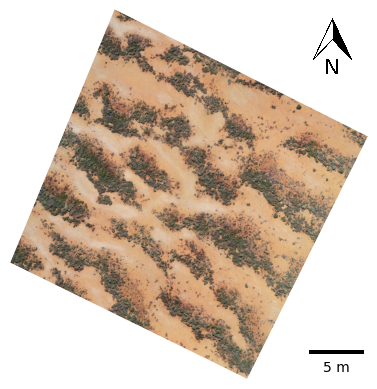

In [298]:
# plot the whole orthomosaic
plt.imshow(image)
plt.axis('off')

scalebar = ScaleBar(0.007, units='m', location='lower right')
plt.gca().add_artist(scalebar)

north_arrow_image = plt.imread('north-arrow.png') 
north_arrow_box = OffsetImage(north_arrow_image, zoom=0.02)
north_arrow_annotation = AnnotationBbox(north_arrow_box, xy=(0.9, 0.9), xycoords='axes fraction', frameon=False)
plt.gca().add_artist(north_arrow_annotation)

plt.savefig('smaller_wscale_ortho_kalabity', bbox_inches='tight', pad_inches=0)

In [215]:
# plot the whole orthomosaic with red, green, blue bands
fig = plt.gcf()

plt.subplot(141)
plt.imshow(image)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='lower right')
plt.gca().add_artist(scalebar)
plt.title('Cropped Kalabity Site')

plt.subplot(142)
plt.pcolormesh(lon[::4], lat[::4], red[::4][:,::4].T)
plt.colorbar(label="Brightness")
plt.axis('square')
plt.title('Red Band')

plt.subplot(143)
plt.pcolormesh(lon[::4], lat[::4], green[::4][:,::4].T)
plt.colorbar(label="Brightness")
plt.axis('square')
plt.title('Green Band')

plt.subplot(144)
plt.pcolormesh(lon[::4], lat[::4], blue[::4][:,::4].T)
plt.colorbar(label="Brightness")
plt.axis('square')
plt.title('Blue Band')

plt.subplots_adjust(hspace=0.7)
fig.set_size_inches(18,3)

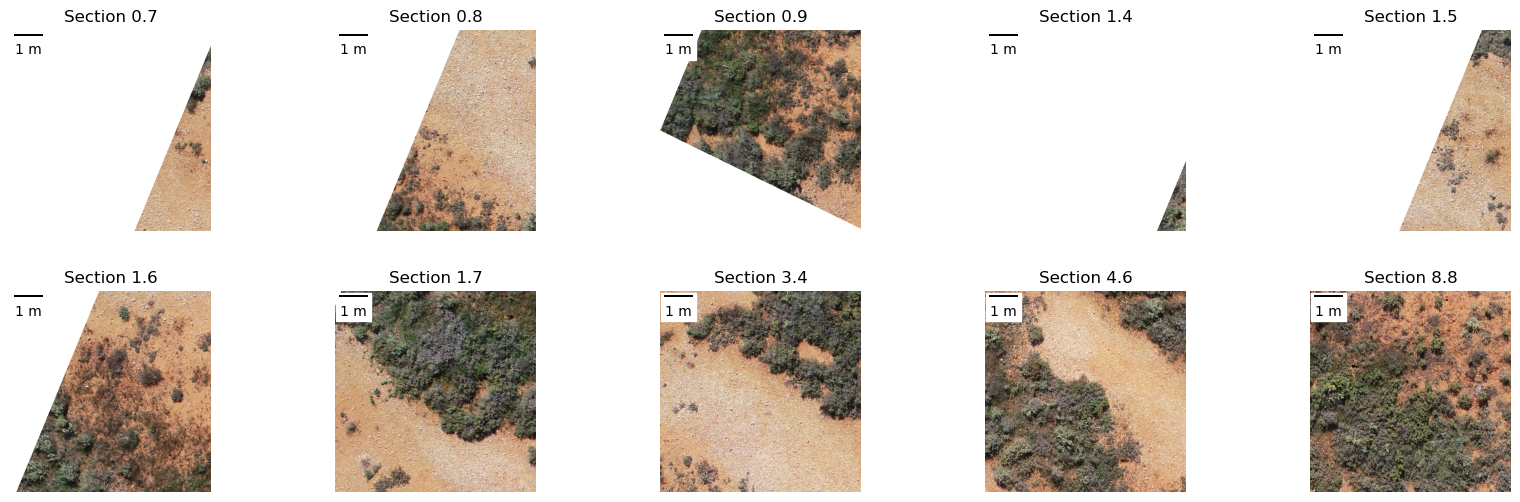

In [5]:
# plot the images of the orthomosaic sections with a scale bar for reference
fig = plt.gcf()

plt.subplot(2,5,1)
plt.imshow(image07)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 0.7')

plt.subplot(2,5,2)
plt.imshow(image08)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 0.8')

plt.subplot(2,5,3)
plt.imshow(image09)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 0.9')

plt.subplot(2,5,4)
plt.imshow(image14)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 1.4')

plt.subplot(2,5,5)
plt.imshow(image15)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 1.5')

plt.subplot(2,5,6)
plt.imshow(image16)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 1.6')

plt.subplot(2,5,7)
plt.imshow(image17)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 1.7')

plt.subplot(2,5,8)
plt.imshow(image34)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 3.4')

plt.subplot(2,5,9)
plt.imshow(image46)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 4.6')

plt.subplot(2,5,10)
plt.imshow(image88)
plt.axis('off')
scalebar = ScaleBar(0.007, units='m', location='upper left')
plt.gca().add_artist(scalebar)
plt.title('Section 8.8')


plt.subplots_adjust(hspace=0.3, wspace=0.3)
fig.set_size_inches(20,6)

plt.savefig('ortho_sections_w_scalebar', bbox_inches='tight', pad_inches=0)

In [234]:
# histograms of section 1.7

fig = plt.gcf()

plt.subplot(131)
hist_raw, bins_raw, _ = plt.hist(r_1_7[~np.isnan(r_1_7)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('red')

plt.subplot(132)
hist_raw, bins_raw, _ = plt.hist(g_1_7[~np.isnan(g_1_7)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('green')

plt.subplot(133)
hist_raw, bins_raw, _ = plt.hist(b_1_7[~np.isnan(b_1_7)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 3, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=3)')
plt.legend(loc='upper left', fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('blue')

plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(12,3)

In [233]:
# histograms of section 3.4

fig = plt.gcf()

plt.subplot(131)
hist_raw, bins_raw, _ = plt.hist(r_3_4[~np.isnan(r_3_4)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('red')

plt.subplot(132)
hist_raw, bins_raw, _ = plt.hist(g_3_4[~np.isnan(g_3_4)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('green')

plt.subplot(133)
hist_raw, bins_raw, _ = plt.hist(b_3_4[~np.isnan(b_3_4)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('blue')

plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(12,3)

In [232]:
# histograms of section 4.6

fig = plt.gcf()

plt.subplot(131)
hist_raw, bins_raw, _ = plt.hist(r_4_6[~np.isnan(r_4_6)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('red')

plt.subplot(132)
hist_raw, bins_raw, _ = plt.hist(g_4_6[~np.isnan(g_4_6)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('green')

plt.subplot(133)
hist_raw, bins_raw, _ = plt.hist(b_4_6[~np.isnan(b_4_6)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('blue')

plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(12,3)

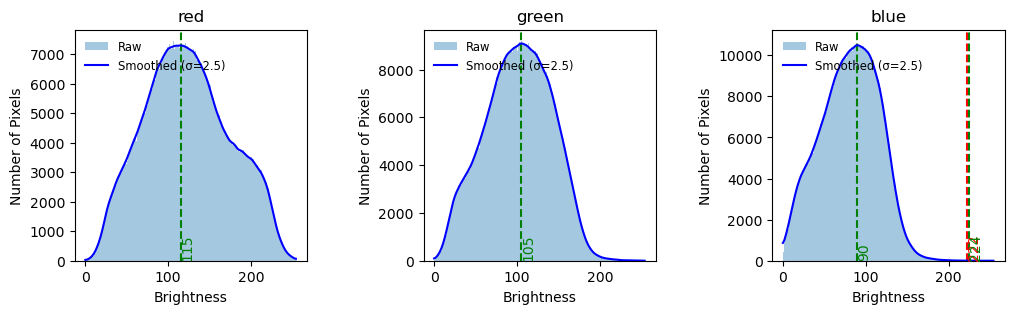

In [231]:
# histograms of section 8.8

fig = plt.gcf()

plt.subplot(131)
hist_raw, bins_raw, _ = plt.hist(r_8_8[~np.isnan(r_8_8)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(loc='upper left', fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('red')

plt.subplot(132)
hist_raw, bins_raw, _ = plt.hist(g_8_8[~np.isnan(g_8_8)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(loc='upper left', fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('green')

plt.subplot(133)
hist_raw, bins_raw, _ = plt.hist(b_8_8[~np.isnan(b_8_8)], bins=np.arange(256), alpha=0.4, label='Raw')
smoothed_hist = smooth_histogram(hist_raw, 2.5, plot_valleys=True, plot_peaks=True)
plt.plot(bins_raw[:-1], smoothed_hist, color='b', label='Smoothed (σ=2.5)')
plt.legend(loc='upper left', fontsize='small', frameon=False)
plt.xlabel('Brightness')
plt.ylabel('Number of Pixels')
plt.title('blue')

plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(12,3)

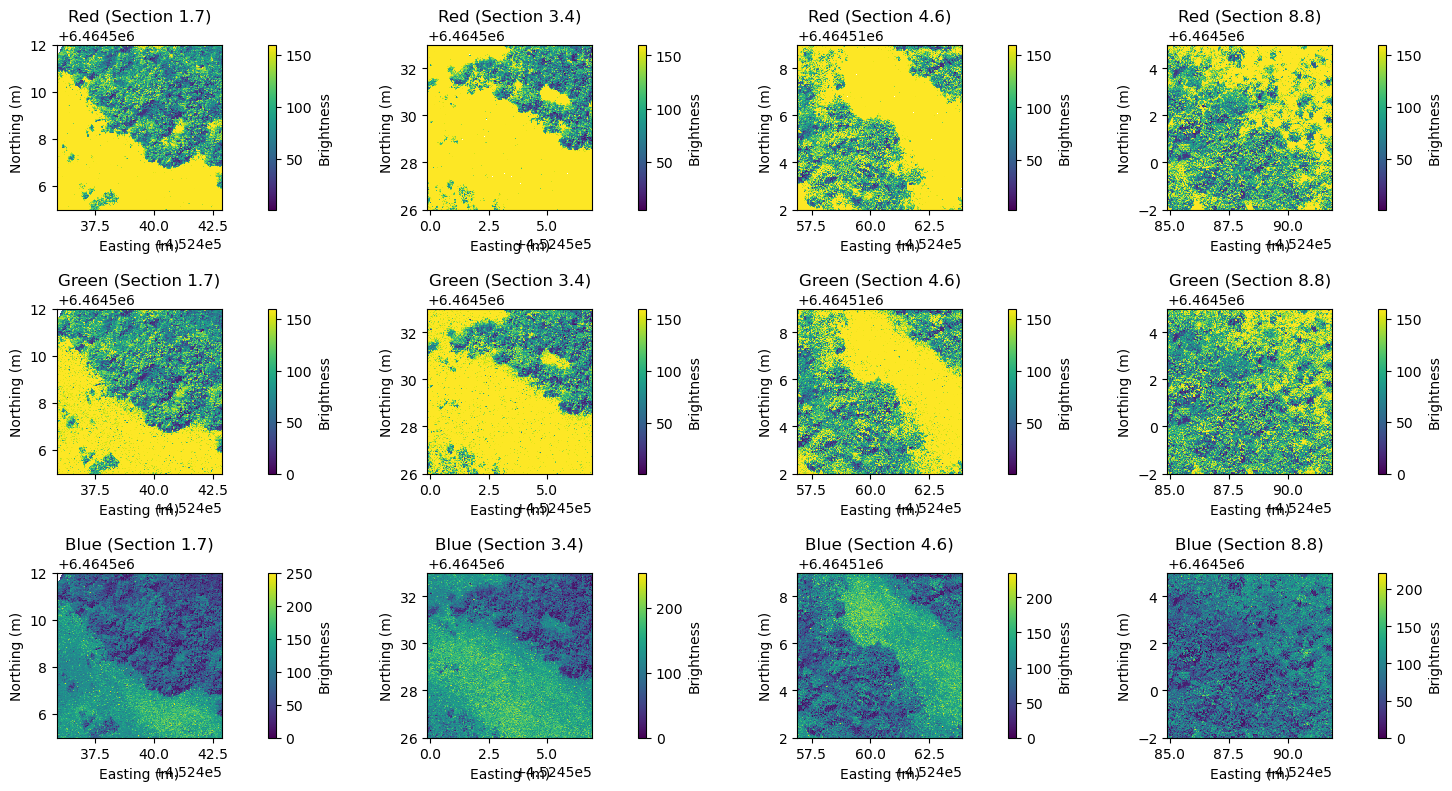

In [240]:
# using histogram maxima and minima to establish thresholds for vegetation. Blue is not effective at discriminating between vegetation and bare ground.
fig = plt.gcf()

# red band
plt.subplot(3,4,1)
plt.pcolormesh(lon_1_7[::4], lat_1_7[::4], r_1_7[::4][:,::4].T, vmax=160)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Red (Section 1.7)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.subplot(3,4,2)
plt.pcolormesh(lon_3_4[::4], lat_3_4[::4], r_3_4[::4][:,::4].T, vmax=160)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Red (Section 3.4)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.subplot(3,4,3)
plt.pcolormesh(lon_4_6[::4], lat_4_6[::4], r_4_6[::4][:,::4].T, vmax=160)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Red (Section 4.6)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.subplot(3,4,4)
plt.pcolormesh(lon_8_8[::4], lat_8_8[::4], r_8_8[::4][:,::4].T, vmax=160)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Red (Section 8.8)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')


# green band
plt.subplot(3,4,5)
plt.pcolormesh(lon_1_7[::4], lat_1_7[::4], g_1_7[::4][:,::4].T, vmax=160)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Green (Section 1.7)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.subplot(3,4,6)
plt.pcolormesh(lon_3_4[::4], lat_3_4[::4], g_3_4[::4][:,::4].T, vmax=160)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Green (Section 3.4)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.subplot(3,4,7)
plt.pcolormesh(lon_4_6[::4], lat_4_6[::4], g_4_6[::4][:,::4].T, vmax=160)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Green (Section 4.6)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.subplot(3,4,8)
plt.pcolormesh(lon_8_8[::4], lat_8_8[::4], g_8_8[::4][:,::4].T, vmax=160)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Green (Section 8.8)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')


# blue band
plt.subplot(3,4,9)
plt.pcolormesh(lon_1_7[::4], lat_1_7[::4], b_1_7[::4][:,::4].T)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Blue (Section 1.7)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.subplot(3,4,10)
plt.pcolormesh(lon_3_4[::4], lat_3_4[::4], b_3_4[::4][:,::4].T)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Blue (Section 3.4)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.subplot(3,4,11)
plt.pcolormesh(lon_4_6[::4], lat_4_6[::4], b_4_6[::4][:,::4].T)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Blue (Section 4.6)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.subplot(3,4,12)
plt.pcolormesh(lon_8_8[::4], lat_8_8[::4], b_8_8[::4][:,::4].T)
plt.colorbar(label='Brightness')
plt.axis('square')
plt.title('Blue (Section 8.8)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')


plt.subplots_adjust(hspace=0.6,wspace=0.3)
fig.set_size_inches(18,9)

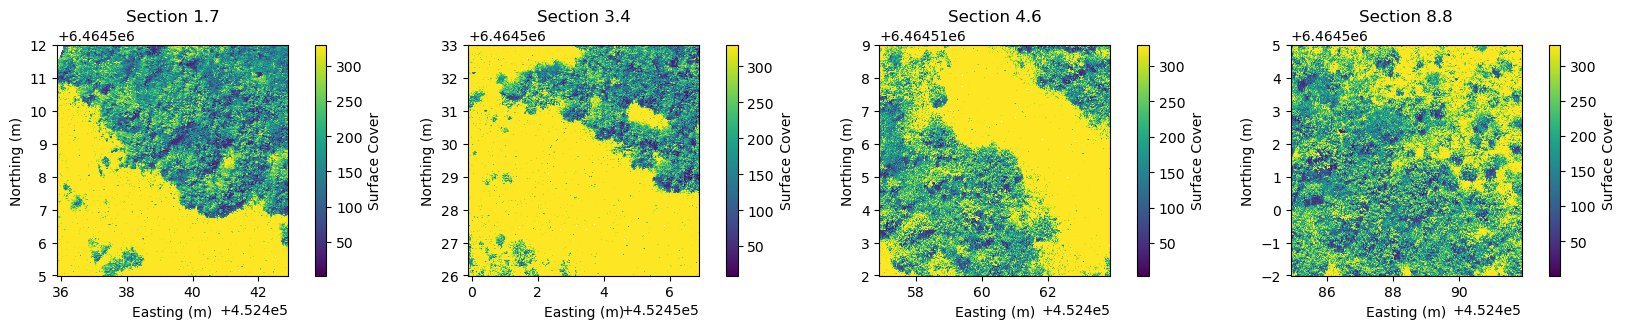

In [258]:
# using just the red and green bands, trialling adding them together to see if this accurately represents the vegetation. 
# not super effective as intergroves seem to have vegetation pixels in them which aren't actually there
fig = plt.gcf()

plt.subplot(141)
plt.pcolormesh(lon_1_7[::4], lat_1_7[::4], (r_1_7+g_1_7)[::4][:,::4].T, vmax=330)
plt.colorbar(label='Surface Cover')
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 1.7')

plt.subplot(142)
plt.pcolormesh(lon_3_4[::4], lat_3_4[::4], (r_3_4+g_3_4)[::4][:,::4].T, vmax=330)
plt.colorbar(label='Surface Cover')
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 3.4')

plt.subplot(143)
plt.pcolormesh(lon_4_6[::4], lat_4_6[::4], (r_4_6+g_4_6)[::4][:,::4].T, vmax=330)
plt.colorbar(label='Surface Cover')
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 4.6')

plt.subplot(144)
plt.pcolormesh(lon_8_8[::4], lat_8_8[::4], (r_8_8+g_8_8)[::4][:,::4].T, vmax=330)
plt.colorbar(label='Surface Cover')
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 8.8')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20,3)

In [264]:
# using just the red and blue bands, trialling where r<170 & g<160 to see if this accurately represents the vegetation
# quite effective with the exception of some shadows in the intergroves from gibber stones. Very effective in separating vegetation from bare soil though
fig = plt.gcf()

plt.subplot(141)
plt.pcolormesh(lon_1_7[::4], lat_1_7[::4], ((r17_masked < 160) & (g17_masked < 160))[::4][:, ::4].T, cmap='Greens')
plt.colorbar(label='Vegetation Cover', ticks=np.linspace(0,1,2))
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 1.7')

plt.subplot(142)
plt.pcolormesh(lon_3_4[::4], lat_3_4[::4], ((r34_masked < 160) & (g34_masked < 160))[::4][:, ::4].T, cmap='Greens')
plt.colorbar(label='Vegetation Cover', ticks=np.linspace(0,1,2))
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 3.4')

plt.subplot(143)
plt.pcolormesh(lon_4_6[::4], lat_4_6[::4], ((r46_masked < 160) & (g46_masked < 160))[::4][:, ::4].T, cmap='Greens')
plt.colorbar(label='Vegetation Cover', ticks=np.linspace(0,1,2))
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 4.6')

plt.subplot(144)
plt.pcolormesh(lon_8_8[::4], lat_8_8[::4], ((r88_masked < 160) & (g88_masked < 160))[::4][:, ::4].T, cmap='Greens')
plt.colorbar(label='Vegetation Cover', ticks=np.linspace(0,1,2))
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 8.8')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20,3)

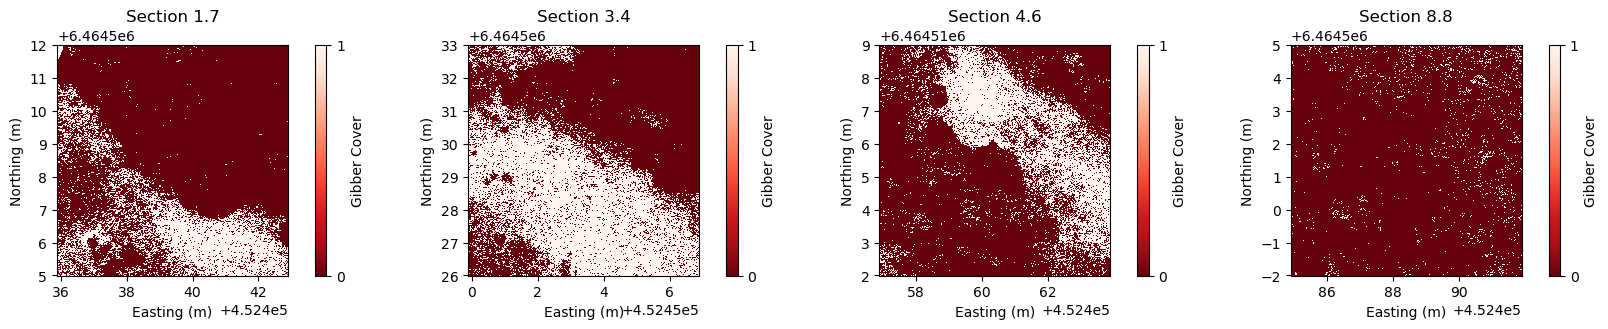

In [268]:
# using histogram maxima and minima to establish thresholds for gibber. 
# setting red and green bands to >160 as we already know that below these values is vegetation
fig = plt.gcf()

plt.subplot(141)
plt.pcolormesh(lon_1_7[::4], lat_1_7[::4], ((r17_masked>160) & (g17_masked>160) & (b17_masked>=135))[::4][:, ::4].T, cmap='Reds_r')
plt.colorbar(label='Gibber Cover', ticks=[0,1])
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 1.7')

plt.subplot(142)
plt.pcolormesh(lon_3_4[::4], lat_3_4[::4], ((r34_masked > 160) & (g34_masked > 160) & (b34_masked>=135))[::4][:, ::4].T, cmap='Reds_r')
plt.colorbar(label='Gibber Cover', ticks=[0,1])
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 3.4')

plt.subplot(143)
plt.pcolormesh(lon_4_6[::4], lat_4_6[::4], ((r46_masked > 160) & (g46_masked > 160) & (b46_masked>=135))[::4][:, ::4].T, cmap='Reds_r')
plt.colorbar(label='Gibber Cover', ticks=[0,1])
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 4.6')

plt.subplot(144)
plt.pcolormesh(lon_8_8[::4], lat_8_8[::4], ((r88_masked > 160) & (g88_masked > 160) & (b88_masked>=135))[::4][:, ::4].T, cmap='Reds_r')
plt.colorbar(label='Gibber Cover', ticks=[0,1])
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 8.8')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20,3)

In [270]:
# plot each of the sections with 0 for vegetation, 1 for bare soil, and 2 for gibber
fig = plt.gcf()

plt.subplot(141)
plt.pcolormesh(lon_1_7[::4], lat_1_7[::4], vbg17[::4][:, ::4].T, cmap='magma')
plt.colorbar(ticks=np.linspace(0,2,3), label='Surface Cover')
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 1.7')

plt.subplot(142)
plt.pcolormesh(lon_3_4[::4], lat_3_4[::4], vbg34[::4][:, ::4].T, cmap='magma')
plt.colorbar(ticks=np.linspace(0,2,3), label='Surface Cover')
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 3.4')

plt.subplot(143)
plt.pcolormesh(lon_4_6[::4], lat_4_6[::4], vbg46[::4][:, ::4].T, cmap='magma')
plt.colorbar(ticks=np.linspace(0,2,3), label='Surface Cover')
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 4.6')

plt.subplot(144)
plt.pcolormesh(lon_8_8[::4], lat_8_8[::4], vbg88[::4][:, ::4].T, cmap='magma')
plt.colorbar(ticks=np.linspace(0,2,3), label='Surface Cover')
plt.axis('square')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Section 8.8')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20,3)

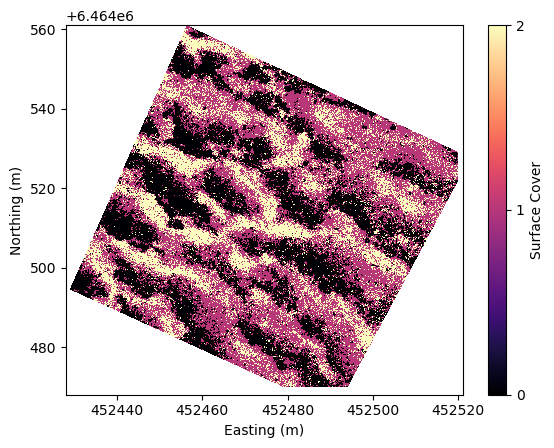

In [284]:
# combine all sections into one plot of surface cover
lon_list = [lon_0_7, lon_0_8, lon_0_9, lon_1_4, lon_1_5, lon_1_6, lon_1_7, lon_1_8, lon_1_9, lon_1_10, lon_2_2, lon_2_3, lon_2_4, lon_2_5, lon_2_6, lon_2_7, lon_2_8, lon_2_9, lon_2_10, lon_3_0, lon_3_1, lon_3_2, lon_3_3, lon_3_4,
            lon_3_5, lon_3_6, lon_3_7, lon_3_8, lon_3_9, lon_3_10, lon_3_11, lon_4_0, lon_4_1, lon_4_2, lon_4_3, lon_4_4, lon_4_5, lon_4_6, lon_4_7, lon_4_8, lon_4_9, lon_4_10, lon_4_11, lon_5_0, lon_5_1, lon_5_2, lon_5_3, lon_5_4, 
            lon_5_5, lon_5_6, lon_5_7, lon_5_8, lon_5_9, lon_5_10, lon_5_11, lon_5_12, lon_6_1, lon_6_2, lon_6_3, lon_6_4, lon_6_5, lon_6_6, lon_6_7, lon_6_8, lon_6_9, lon_6_10, lon_6_11, lon_6_12, lon_7_1, lon_7_2, lon_7_3, lon_7_4, 
            lon_7_5, lon_7_6, lon_7_7, lon_7_8, lon_7_9, lon_7_10, lon_7_11, lon_7_12, lon_8_2, lon_8_3, lon_8_4, lon_8_5, lon_8_6, lon_8_7, lon_8_8, lon_8_9, lon_8_10, lon_8_11, lon_8_12, lon_9_2, lon_9_3, lon_9_4, lon_9_5, lon_9_6, 
            lon_9_7, lon_9_8, lon_9_9, lon_9_10, lon_9_11, lon_9_12, lon_10_3, lon_10_4, lon_10_5, lon_10_6, lon_10_7, lon_10_8, lon_10_9, lon_10_10, lon_10_11, lon_11_3, lon_11_4, lon_11_5, lon_11_6, lon_11_7, lon_11_8, lon_11_9, 
            lon_12_4, lon_12_5, lon_12_6, lon_12_7]

lat_list = [lat_0_7, lat_0_8, lat_0_9, lat_1_4, lat_1_5, lat_1_6, lat_1_7, lat_1_8, lat_1_9, lat_1_10, lat_2_2, lat_2_3, lat_2_4, lat_2_5, lat_2_6, lat_2_7, lat_2_8, lat_2_9, lat_2_10, lat_3_0, lat_3_1, lat_3_2, lat_3_3, lat_3_4, 
            lat_3_5, lat_3_6, lat_3_7, lat_3_8, lat_3_9, lat_3_10, lat_3_11, lat_4_0, lat_4_1, lat_4_2, lat_4_3, lat_4_4, lat_4_5, lat_4_6, lat_4_7, lat_4_8, lat_4_9, lat_4_10, lat_4_11, lat_5_0, lat_5_1, lat_5_2, lat_5_3, lat_5_4, 
            lat_5_5, lat_5_6, lat_5_7, lat_5_8, lat_5_9, lat_5_10, lat_5_11, lat_5_12, lat_6_1, lat_6_2, lat_6_3, lat_6_4, lat_6_5, lat_6_6, lat_6_7, lat_6_8, lat_6_9, lat_6_10, lat_6_11, lat_6_12, lat_7_1, lat_7_2, lat_7_3, lat_7_4, 
            lat_7_5, lat_7_6, lat_7_7, lat_7_8, lat_7_9, lat_7_10, lat_7_11, lat_7_12, lat_8_2, lat_8_3, lat_8_4, lat_8_5, lat_8_6, lat_8_7, lat_8_8, lat_8_9, lat_8_10, lat_8_11, lat_8_12, lat_9_2, lat_9_3, lat_9_4, lat_9_5, lat_9_6,
            lat_9_7, lat_9_8, lat_9_9, lat_9_10, lat_9_11, lat_9_12, lat_10_3, lat_10_4, lat_10_5, lat_10_6, lat_10_7, lat_10_8, lat_10_9, lat_10_10, lat_10_11, lat_11_3, lat_11_4, lat_11_5, lat_11_6, lat_11_7, lat_11_8, lat_11_9,
            lat_12_4, lat_12_5, lat_12_6, lat_12_7]

vbg_list = [vbg07, vbg08, vbg09, vbg14, vbg15, vbg16, vbg17, vbg18, vbg19, vbg110, vbg22, vbg23, vbg24, vbg25, vbg26, vbg27, vbg28, vbg29, vbg210, vbg30, vbg31, vbg32, vbg33, vbg34, vbg35, vbg36, vbg37, vbg38, vbg39, vbg310, vbg311,
            vbg40, vbg41, vbg42, vbg43, vbg44, vbg45, vbg46, vbg47, vbg48, vbg49, vbg410, vbg411, vbg50, vbg51, vbg52, vbg53, vbg54, vbg55, vbg56, vbg57, vbg58, vbg59, vbg510, vbg511, vbg512, vbg61, vbg62, vbg63, vbg64, vbg65, vbg66,
            vbg67, vbg68, vbg69, vbg610, vbg611, vbg612, vbg71, vbg72, vbg73, vbg74, vbg75, vbg76, vbg77, vbg78, vbg79, vbg710, vbg711, vbg712, vbg82, vbg83, vbg84, vbg85, vbg86, vbg87, vbg88, vbg89, vbg810, vbg811, vbg812, vbg92,
            vbg93, vbg94, vbg95, vbg96, vbg97, vbg98, vbg99, vbg910, vbg911, vbg912, vbg103, vbg104, vbg105, vbg106, vbg107, vbg108, vbg109, vbg1010, vbg1011, vbg113, vbg114, vbg115, vbg116, vbg117, vbg118, vbg119, vbg124, vbg125,
            vbg126, vbg127]

fig, ax = plt.subplots()

for lon, lat, vbg in zip(lon_list, lat_list, vbg_list):
    im = ax.pcolormesh(lon[::2], lat[::2], vbg[::2][:, ::2].T, cmap='magma')
        
cbar = plt.colorbar(im, ax=ax, ticks=np.linspace(0,2,3), label='Surface Cover')

ax.set_xlim(452428, 452521)
ax.set_ylim(6464468, 6464561)

plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.savefig('surface_cover_cropped_kalabity', dpi=300)

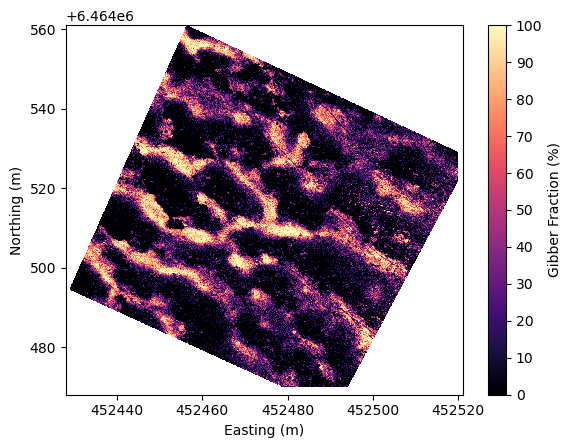

In [283]:
lon_list = [lon_0_7, lon_0_8, lon_0_9, lon_1_4, lon_1_5, lon_1_6, lon_1_7, lon_1_8, lon_1_9, lon_1_10, lon_2_2, lon_2_3, lon_2_4, lon_2_5, lon_2_6, lon_2_7, lon_2_8, lon_2_9, lon_2_10, lon_3_0, lon_3_1, lon_3_2, lon_3_3, lon_3_4,
            lon_3_5, lon_3_6, lon_3_7, lon_3_8, lon_3_9, lon_3_10, lon_3_11, lon_4_0, lon_4_1, lon_4_2, lon_4_3, lon_4_4, lon_4_5, lon_4_6, lon_4_7, lon_4_8, lon_4_9, lon_4_10, lon_4_11, lon_5_0, lon_5_1, lon_5_2, lon_5_3, lon_5_4, 
            lon_5_5, lon_5_6, lon_5_7, lon_5_8, lon_5_9, lon_5_10, lon_5_11, lon_5_12, lon_6_1, lon_6_2, lon_6_3, lon_6_4, lon_6_5, lon_6_6, lon_6_7, lon_6_8, lon_6_9, lon_6_10, lon_6_11, lon_6_12, lon_7_1, lon_7_2, lon_7_3, lon_7_4, 
            lon_7_5, lon_7_6, lon_7_7, lon_7_8, lon_7_9, lon_7_10, lon_7_11, lon_7_12, lon_8_2, lon_8_3, lon_8_4, lon_8_5, lon_8_6, lon_8_7, lon_8_8, lon_8_9, lon_8_10, lon_8_11, lon_8_12, lon_9_2, lon_9_3, lon_9_4, lon_9_5, lon_9_6, 
            lon_9_7, lon_9_8, lon_9_9, lon_9_10, lon_9_11, lon_9_12, lon_10_3, lon_10_4, lon_10_5, lon_10_6, lon_10_7, lon_10_8, lon_10_9, lon_10_10, lon_10_11, lon_11_3, lon_11_4, lon_11_5, lon_11_6, lon_11_7, lon_11_8, lon_11_9, 
            lon_12_4, lon_12_5, lon_12_6, lon_12_7]

lat_list = [lat_0_7, lat_0_8, lat_0_9, lat_1_4, lat_1_5, lat_1_6, lat_1_7, lat_1_8, lat_1_9, lat_1_10, lat_2_2, lat_2_3, lat_2_4, lat_2_5, lat_2_6, lat_2_7, lat_2_8, lat_2_9, lat_2_10, lat_3_0, lat_3_1, lat_3_2, lat_3_3, lat_3_4, 
            lat_3_5, lat_3_6, lat_3_7, lat_3_8, lat_3_9, lat_3_10, lat_3_11, lat_4_0, lat_4_1, lat_4_2, lat_4_3, lat_4_4, lat_4_5, lat_4_6, lat_4_7, lat_4_8, lat_4_9, lat_4_10, lat_4_11, lat_5_0, lat_5_1, lat_5_2, lat_5_3, lat_5_4, 
            lat_5_5, lat_5_6, lat_5_7, lat_5_8, lat_5_9, lat_5_10, lat_5_11, lat_5_12, lat_6_1, lat_6_2, lat_6_3, lat_6_4, lat_6_5, lat_6_6, lat_6_7, lat_6_8, lat_6_9, lat_6_10, lat_6_11, lat_6_12, lat_7_1, lat_7_2, lat_7_3, lat_7_4, 
            lat_7_5, lat_7_6, lat_7_7, lat_7_8, lat_7_9, lat_7_10, lat_7_11, lat_7_12, lat_8_2, lat_8_3, lat_8_4, lat_8_5, lat_8_6, lat_8_7, lat_8_8, lat_8_9, lat_8_10, lat_8_11, lat_8_12, lat_9_2, lat_9_3, lat_9_4, lat_9_5, lat_9_6,
            lat_9_7, lat_9_8, lat_9_9, lat_9_10, lat_9_11, lat_9_12, lat_10_3, lat_10_4, lat_10_5, lat_10_6, lat_10_7, lat_10_8, lat_10_9, lat_10_10, lat_10_11, lat_11_3, lat_11_4, lat_11_5, lat_11_6, lat_11_7, lat_11_8, lat_11_9,
            lat_12_4, lat_12_5, lat_12_6, lat_12_7]

g_f_list = [g_f07, g_f08, g_f09, g_f14, g_f15, g_f16, g_f17, g_f18, g_f19, g_f110, g_f22, g_f23, g_f24, g_f25, g_f26, g_f27, g_f28, g_f29, g_f210, g_f30, g_f31, g_f32, g_f33, g_f34, g_f35, g_f36, g_f37, g_f38, g_f39, g_f310, g_f311,
            g_f40, g_f41, g_f42, g_f43, g_f44, g_f45, g_f46, g_f47, g_f48, g_f49, g_f410, g_f411, g_f50, g_f51, g_f52, g_f53, g_f54, g_f55, g_f56, g_f57, g_f58, g_f59, g_f510, g_f511, g_f512, g_f61, g_f62, g_f63, g_f64, g_f65, g_f66,
            g_f67, g_f68, g_f69, g_f610, g_f611, g_f612, g_f71, g_f72, g_f73, g_f74, g_f75, g_f76, g_f77, g_f78, g_f79, g_f710, g_f711, g_f712, g_f82, g_f83, g_f84, g_f85, g_f86, g_f87, g_f88, g_f89, g_f810, g_f811, g_f812, g_f92,
            g_f93, g_f94, g_f95, g_f96, g_f97, g_f98, g_f99, g_f910, g_f911, g_f912, g_f103, g_f104, g_f105, g_f106, g_f107, g_f108, g_f109, g_f1010, g_f1011, g_f113, g_f114, g_f115, g_f116, g_f117, g_f118, g_f119, g_f124, g_f125,
            g_f126, g_f127]

fig, ax = plt.subplots()

for lon, lat, g_f in zip(lon_list, lat_list, g_f_list):
    im = ax.pcolormesh(lon[::10], lat[::10], g_f.T, vmin=0, vmax=100, cmap='magma')
        
cbar = plt.colorbar(im, ax=ax, ticks=np.linspace(0,100,11), label='Gibber Fraction (%)')

ax.set_xlim(452428, 452521)
ax.set_ylim(6464468, 6464561)

plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.savefig('gibber_fraction_cropped_kalabity', dpi=300)